In [1]:
from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer, GPTNeoXForCausalLM, RobertaTokenizer, RobertaForSequenceClassification
import torch
from torch import nn
import glob
from tqdm import tqdm
import re
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from scipy.spatial.distance import cosine
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Set the seaborn style
sns.set_style("whitegrid")
sns.set_palette("deep")

# Configure Matplotlib to use LaTeX for rendering
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use serif font in conjunction with LaTeX
    "text.latex.preamble": r"\usepackage{times}",
    })

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
dataset_name = 'jaredjoss/jigsaw-long-2000'
dataset = load_dataset(dataset_name)
df = pd.DataFrame(dataset['train'])
df['full_text'] = df['prompt'] + ' ' + df['original_output']
df

,prompt,original_output,toxic,full_text
0,""" ==Speedy deletion of Mariana Zara== A tag ha...",well as our subject-specific notability guidel...,0,""" ==Speedy deletion of Mariana Zara== A tag ha..."
1,I'm with ^^^ == Speculation == I try my best t...,"and left it, so why are you still moaning? To ...",0,I'm with ^^^ == Speculation == I try my best t...
2,Murali == Please don't revert my edits without...,reasoning - just makes you look stupid. ==,1,Murali == Please don't revert my edits without...
3,""" :::You're a real pair of Nazi-infatuated knu...",have somehow created such a powerful precedenc...,0,""" :::You're a real pair of Nazi-infatuated knu..."
4,The Fresh Meat 2 guide needs to be,deleted because nothing but bullshit is on it.,1,The Fresh Meat 2 guide needs to be deleted bec...
...,...,...,...,...
1995,i think i want to know how the sperm looks lik...,you every know and you guys are come from your...,1,i think i want to know how the sperm looks lik...
1996,== Categorization of Turkish Cypriot politicia...,so big that we broke it up by continent. I sus...,0,== Categorization of Turkish Cypriot politicia...
1997,LOL uncle Dick needs no harassment because hes...,a name that reminds of the male reproductive o...,1,LOL uncle Dick needs no harassment because hes...
1998,":Trolling again, Cwobeel? You need to learn how","to stop shooting off your mouth, right?",1,":Trolling again, Cwobeel? You need to learn ho..."


In [3]:
def lp_norm(x, y, p):
    """
    Returns the lp norm between two lists.
    """
    # Ensure both x and y are numpy arrays for element-wise operations
    x = np.array(x)
    y = np.array(y)
    
    # Calculate the lp norm
    diff = np.abs(x - y)
    lp_norm_value = np.sum(diff**p)**(1/p)
    return lp_norm_value

def calculate_accuracy_f1(true_rewards, learned_rewards):
    true_rewards_labels = [0 if reward > 0 else 1 for reward in true_rewards]
    learned_rewards_labels = [0 if reward > 0 else 1 for reward in learned_rewards]
    return accuracy_score(true_rewards_labels, learned_rewards_labels), f1_score(true_rewards_labels, learned_rewards_labels)

In [4]:
def get_reward_score(reward_model, input_text, tokenizer, true_reward=False, show_output=False):
    """
    Takes reward model and input and returns reward score. 
    """
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)#.to(device)
    # reward_model = reward_model.to(device)
    
    if show_output:
        print("REWARD MODEL: " , reward_model(input_ids))

    if true_reward:
        output = reward_model(input_ids).logits
    else:
        output = reward_model(input_ids)

    output = -1*output[:, -1]
    return output

In [5]:
class RewardModel(nn.Module):
    def __init__(self, checkpoint_path, eos_token_id):
        super().__init__()
        # model = AutoModelForCausalLM.from_pretrained(checkpoint_path)
        model = GPTNeoXForCausalLM.from_pretrained(checkpoint_path)
        self.model = model
        self.v_head = nn.Linear(model.gpt_neox.embed_in.embedding_dim, 2, bias=False)  # TODO make not magic number
        self.eos_token_id = eos_token_id
    def forward(self, input_ids):
        returns = self.model(input_ids, output_hidden_states=True).hidden_states[-1][:, -1, :]#[0] #, 1)
        # print("Returns : ", returns.shape, returns)
        returns_2 = self.v_head(returns)
        # Applying softmax to returns_2 along the last dimension
        # returns_2 = torch.nn.functional.softmax(returns_2, dim=-1).squeeze(-1)
        # print("Returns : ", returns.shape, returns_2)
        return returns_2

In [6]:
def get_initial_model(learn_rm):
    """
    Returns initial reward model. 
    """
    # if learn_rm == "EleutherAI/pythia-70m":
    reward_tokenizer = AutoTokenizer.from_pretrained(learn_rm)
    reward_model = RewardModel(learn_rm, reward_tokenizer.eos_token_id)
    reward_model.eval()
    # return reward_model, reward_tokenizer
    return reward_model.requires_grad_(), reward_tokenizer

def get_true_reward_model(true_rm = "s-nlp/roberta_toxicity_classifier"):
    """
    Returns true reward model. 
    """
    if true_rm == "s-nlp/roberta_toxicity_classifier":
        # load tokenizer and model weights
        reward_tokenizer = RobertaTokenizer.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')
        reward_model = RobertaForSequenceClassification.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')#.to(device)

        return reward_model, reward_tokenizer
    
def load_saved_model(checkpoint_path, learn_rm):
    """
    Loads a saved model state from the given checkpoint path.
    """
    reward_tokenizer = AutoTokenizer.from_pretrained(learn_rm)
    reward_model = RewardModel(learn_rm, reward_tokenizer.eos_token_id)
    reward_model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    reward_model.eval()
    # reward_model.to(device)
    # return reward_model, reward_tokenizer
    return reward_model.requires_grad_(), reward_tokenizer

In [7]:
# settings
learn_rm = 'EleutherAI/pythia-70m'
checkpoint_path = '../output/irl/models/rirl_v2/learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifierlr_5e-05_loss_max_margin_14_epochs_eps_-1000000_corr_0.66_early.pt'

pre_irl_model, pre_irl_tokenizer = get_initial_model(learn_rm)
true_reward_model, true_rm_tokenizer = get_true_reward_model()
irl_reward_model, irl_rm_tokenizer = load_saved_model(checkpoint_path, learn_rm)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [85]:
# test - get reward score
input_text = df[df['toxic'] == 0].iloc[1]['full_text']

pre_irl_reward = get_reward_score(pre_irl_model, input_text, pre_irl_tokenizer, true_reward=False, show_output=True).detach().cpu().item()
true_reward = get_reward_score(true_reward_model, input_text, true_rm_tokenizer, true_reward=True, show_output=True).detach().cpu().item()
irl_reward = get_reward_score(irl_reward_model, input_text, irl_rm_tokenizer, true_reward=False, show_output=True).detach().cpu().item()

print("Reward Score: ", pre_irl_reward)
print("True Reward Score: ", true_reward)
print("IRL Reward Score: ", irl_reward)

REWARD MODEL:  tensor([[-15.7717,  28.5281]], grad_fn=<MmBackward0>)
REWARD MODEL:  SequenceClassifierOutput(loss=None, logits=tensor([[ 4.5512, -4.6652]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
REWARD MODEL:  tensor([[-2.2760, 72.0041]], grad_fn=<MmBackward0>)
Reward Score:  -28.528141021728516
True Reward Score:  4.6651611328125
IRL Reward Score:  -72.00407409667969


In [86]:
df[df['toxic'] == 0].iloc[185]['full_text']

'" AND . I\'m holding a discussion for the moment now. I can\'t talk on the sockpuppet investigation thingy you guys had about me. So I want to talk to you guys here. I want to talk about my emergence of editing Wikipedia and how I was first a novice but then I started using other stuff on how to learn how to use Wikipedia. It\'s because when I had this account I didn\'t know how to cite sources correctly and I didn\'t understand the Wikipolicy very well. But yet I tried submitting an unblock request once with a ticket system, but I didn\'t get any response. Not anything. So I decided it would be a decision to make another account or use IP versions instead because my requests weren\'t noticed. I didn\'t know about sockpuppetry and that it was wrong. Mostly because a lot of people on like social networks make new accounts after suspension. But the thing about editing is when I first edited, I got really excited and was like ""This is fun! I want to edit more stuff. Just look for some s

In [87]:
# inference
true_rm_batch = true_rm_tokenizer.encode(input_text, return_tensors='pt')
true_reward_model(true_rm_batch)

SequenceClassifierOutput(loss=None, logits=tensor([[ 4.5512, -4.6652]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [88]:
# calculate reward for subset of jaredjoss/jigsaw-2000 dataset using the reward functions
df_sub = df.head(500).copy()
df_sub['pre_irl_reward'] = df_sub['full_text'].apply(lambda text: get_reward_score(pre_irl_model, text, pre_irl_tokenizer).detach().cpu().item())
df_sub['true_reward'] = df_sub['full_text'].apply(lambda text: get_reward_score(true_reward_model, text, true_rm_tokenizer, true_reward=True).detach().cpu().item())
df_sub['irl_reward'] = df_sub['full_text'].apply(lambda text: get_reward_score(irl_reward_model, text, irl_rm_tokenizer).detach().cpu().item())

df_sub

,prompt,original_output,toxic,full_text,pre_irl_reward,true_reward,irl_reward
0,""" ==Speedy deletion of Mariana Zara== A tag ha...",well as our subject-specific notability guidel...,0,""" ==Speedy deletion of Mariana Zara== A tag ha...",-28.069187,5.069046,-65.537567
1,I'm with ^^^ == Speculation == I try my best t...,"and left it, so why are you still moaning? To ...",0,I'm with ^^^ == Speculation == I try my best t...,-28.528141,4.665161,-72.004074
2,Murali == Please don't revert my edits without...,reasoning - just makes you look stupid. ==,1,Murali == Please don't revert my edits without...,-29.015444,-2.564593,-90.972389
3,""" :::You're a real pair of Nazi-infatuated knu...",have somehow created such a powerful precedenc...,0,""" :::You're a real pair of Nazi-infatuated knu...",-27.993420,2.135628,-71.798065
4,The Fresh Meat 2 guide needs to be,deleted because nothing but bullshit is on it.,1,The Fresh Meat 2 guide needs to be deleted bec...,-28.989326,-2.065334,-78.659805
...,...,...,...,...,...,...,...
495,"== Obama Sucks == So does McCain, And",Wikipedia is Gay Thank You for your time,1,"== Obama Sucks == So does McCain, And Wikipedi...",-28.527725,-2.661819,-73.758347
496,""". If it is such a waste of """"precious dick","space"""" then how did you come to find it. Jack...",1,""". If it is such a waste of """"precious dick sp...",-30.323683,-2.872031,-82.848679
497,"In response to Fernando Rodriguez, the only ig...",in Spain today so I am not surprised with all ...,0,"In response to Fernando Rodriguez, the only ig...",-28.113791,-1.957223,-66.401947
498,""":whose """"nationalists""""? Moscovitian? Agreed....",of ukraine. It was ugly and antinatural and im...,0,""":whose """"nationalists""""? Moscovitian? Agreed....",-27.890560,2.281850,-68.615067


In [89]:
true_rewards = df_sub['true_reward']
learned_rewards = df_sub['irl_reward']
np.corrcoef(true_rewards, learned_rewards)[0, 1]
pearson_correlation = np.corrcoef(true_rewards, learned_rewards)[0,1]
euc_norm = lp_norm(true_rewards, learned_rewards, 2)
kendall_tau = stats.kendalltau(true_rewards, learned_rewards)[0]
spearman = stats.spearmanr(true_rewards, learned_rewards)[0]
cosine_sim = 1 - cosine(true_rewards, learned_rewards)
mse = mean_squared_error(true_rewards, learned_rewards)
accuracy, f1 = calculate_accuracy_f1(true_rewards, learned_rewards)
                                
print("Correlation between true and learned reward models: ", pearson_correlation)
print("Euclidean distance between true and learned reward models: ", euc_norm)
print("kendall_tau between true and learned reward models: ", kendall_tau)
print("spearman between true and learned reward models: ", spearman)
print("mse between true and learned reward models: ", mse)
print("Accuracy between true and learned reward models: ", accuracy)
print("F1 Score between true and learned reward models: ", f1)

Correlation between true and learned reward models:  0.6576819362640407
Euclidean distance between true and learned reward models:  1740.8802503991967
kendall_tau between true and learned reward models:  0.46675751503006
spearman between true and learned reward models:  0.6831757887031548
mse between true and learned reward models:  6061.32809245994
Accuracy between true and learned reward models:  0.458
F1 Score between true and learned reward models:  0.6282578875171467


In [69]:
len(df_sub[df_sub['irl_reward'] < 0])

500

In [232]:
# calculate toxicity for every text in the jaredjoss/jigsaw-2000 dataset using the reward functions
df['pre_irl_reward'] = df['full_text'].apply(lambda text: get_reward_score(pre_irl_model, text, pre_irl_tokenizer).detach().cpu().item())
df['true_reward'] = df['full_text'].apply(lambda text: get_reward_score(true_reward_model, text, true_rm_tokenizer, true_reward=True).detach().cpu().item())
df['irl_reward'] = df['full_text'].apply(lambda text: get_reward_score(irl_reward_model, text, irl_rm_tokenizer).detach().cpu().item())

In [12]:
df[['full_text', 'toxic', 'true_reward']]

In [8]:
# function to contruct a name for the model based on file name
def construct_name(text):
    name = ""
    lr = re.findall(r'lr_(.*?)(_|.pt)', text)
    name += "lr_" + lr[0][0] if len(lr) != 0 else ""
    epochs = re.findall(r'_(\d+)_epochs', text)
    name += "_epochs_" + epochs[0] if len(epochs) != 0 else ""
    corr = re.findall(r'orr_(.*?).pt', text)
    name += "_corr_" + corr[0] if len(corr) != 0 else ""
    repeated = re.search(r'_repeated_(\d+)', text)
    name += "_repeated_" + repeated.group(1) if repeated else ""

    return name

In [9]:
## correlation
def compare_correlation(df, subset, learn_rm, checkpoint_paths):
    # create subset of dataset
    df_sub = df.copy()
    if subset > 0:
        df_sub = df_sub.head(subset)
    # load RMs
    pre_irl_model, pre_irl_tokenizer = get_initial_model(learn_rm)
    true_reward_model, true_rm_tokenizer = get_true_reward_model()

    # calculate reward for subset of jaredjoss/jigsaw-2000 dataset using the RMs
    df_sub['pre_irl_reward'] = df_sub['full_text'].apply(lambda text: get_reward_score(pre_irl_model, text, pre_irl_tokenizer).detach().cpu().item())
    df_sub['true_reward'] = df_sub['full_text'].apply(lambda text: get_reward_score(true_reward_model, text, true_rm_tokenizer, true_reward=True).detach().cpu().item())

    # calculate reward for each IRL RM
    for checkpoint_path in checkpoint_paths:
        irl_reward_model, irl_rm_tokenizer = load_saved_model(checkpoint_path, learn_rm)
        df_sub[construct_name(checkpoint_path)] = df_sub['full_text'].apply(lambda text: get_reward_score(irl_reward_model, text, irl_rm_tokenizer).detach().cpu().item())
    
    return df_sub

In [29]:
subset = 500
learn_rm = 'EleutherAI/pythia-70m'
checkpoint_paths = glob.glob('../output/irl/models/all/*.pt')

df_corr = compare_correlation(df, subset, learn_rm, checkpoint_paths)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
# List of columns to calculate correlations with 'true_reward'
columns_to_check = [col for col in df_corr.columns if col.startswith('lr')]
columns_to_check.append('pre_irl_reward')

# Calculate correlation beyween true RM and IRL RMs
correlations = {}
for col in columns_to_check:
    # Extract the data for true_reward and the current column
    data_pair = df_corr[['true_reward', col]].dropna()
    # Calculate the correlation matrix
    correlation_matrix = np.corrcoef(data_pair['true_reward'], data_pair[col])
    # Extract the correlation coefficient
    correlation = correlation_matrix[0, 1]
    correlations[col] = correlation

# Convert correlations to a DataFrame for easy plotting
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Column', 'Correlation'])
correlation_df

,Column,Correlation
0,lr_0.0001_epochs_29_corr_0.63,0.674499
1,lr_0.0001_epochs_29_corr_0.53,0.513810
2,lr_0.0001_epochs_29_corr_0.54,0.554905
3,pre_irl_reward,-0.052058


In [ ]:
# true_rewards = df_sub['true_reward'].tolist()
# learned_rewards = df_sub['irl_reward'].tolist()
# correlation = np.corrcoef(true_rewards, learned_rewards)
                                
# print("Correlation between true and learned reward models: ", correlation[0,1]) 

# Compare Extracted Reward Model to GT RM

In [10]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [11]:
def get_reward_scores(df, irl_paths, size):
    if size == '70m':
        learn_rm = 'EleutherAI/pythia-70m'
    elif size == '410m':
        learn_rm = 'EleutherAI/pythia-410m'
    true_reward_model, true_rm_tokenizer = get_true_reward_model()

    # calculate toxicity jaredjoss/jigsaw-2000 dataset using the reward functions
    df_sub = df.copy()
    texts = df_sub['full_text'].tolist()

    rewards = {}
    rewards['true_reward'] = [x for x in map(lambda text: get_reward_score(true_reward_model, text, true_rm_tokenizer, true_reward=True).detach().cpu().item(), texts)]
    for path in tqdm(irl_paths):
        irl_reward_model, irl_rm_tokenizer = load_saved_model(path, learn_rm)
        rewards[path.split('/')[-1]] = [x for x in map(lambda text: get_reward_score(irl_reward_model, text, irl_rm_tokenizer).detach().cpu().item(), texts)]
    return rewards

def extract_label_from_reward(rewards):
    labels = {}
    for key in rewards.keys():
        labels[key] = [0 if reward > 0 else 1 for reward in rewards[key]]
    return labels

def get_reward_comparison(irl_labels):
    comparison_df = pd.DataFrame(irl_labels)
    # Calculate percentages for each comparison
    percentages = {}

    for column in comparison_df.columns[1:]:  # Skip the 'true_reward' column
        overall_equal = (comparison_df['true_reward'] == comparison_df[column]).mean() * 100
        equal_1_1 = ((comparison_df['true_reward'] == 1) & (comparison_df[column] == 1)).mean() * 100
        equal_0_0 = ((comparison_df['true_reward'] == 0) & (comparison_df[column] == 0)).mean() * 100

        title = construct_name(column)
        percentages[title] = {
            'Overall': overall_equal,
            'true_reward_1': equal_1_1,
            'true_reward_0': equal_0_0
        }

    # Convert dictionary to DataFrame
    percentages_df = pd.DataFrame.from_dict(percentages, orient='index').reset_index()
    percentages_df.columns = ['Model', 'Overall', 'true_reward_1', 'true_reward_0']
    return percentages_df

# calculate lp norm
def lp_norm(x, y, p):
    """
    Returns the lp norm between two lists.
    """
    # Ensure both x and y are numpy arrays for element-wise operations
    x = np.array(x)
    y = np.array(y)
    
    # Calculate the lp norm
    diff = np.abs(x - y)
    lp_norm_value = np.sum(diff**p)**(1/p)
    return lp_norm_value

def reward_metrics(irl_rewards, norm=2):
    rewards_df = pd.DataFrame(irl_rewards)
    results = []
    for column in rewards_df.columns[1:]:
        results.append({
            'model': construct_name(column),
            'correlation': np.corrcoef(rewards_df['true_reward'], rewards_df[column])[0, 1],
            'norm': lp_norm(rewards_df['true_reward'], rewards_df[column], norm)
        })
    return results

In [35]:
# load irl models, calculate rewards and extract labels
irl_models = glob.glob('../output/irl/models/all/*.pt')
irl_rewards = get_reward_scores(df, irl_models, size='70m')
irl_labels = extract_label_from_reward(irl_rewards)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3/3 [04:05<00:00, 81.88s/it]


In [36]:
list(irl_labels.keys())

['true_reward',
 'learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifierlr_0.0001_ss_100_29_epochs_oriCorr_0.63.pt',
 'learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifierlr_0.0001_ss_100_29_epochs_oriCorr_0.53.pt',
 'learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifierlr_0.0001_ss_100_29_epochs_oriCorr_0.54.pt']

/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_67581/3913004773.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Overall', data=reward_comparsion_df, palette='viridis')


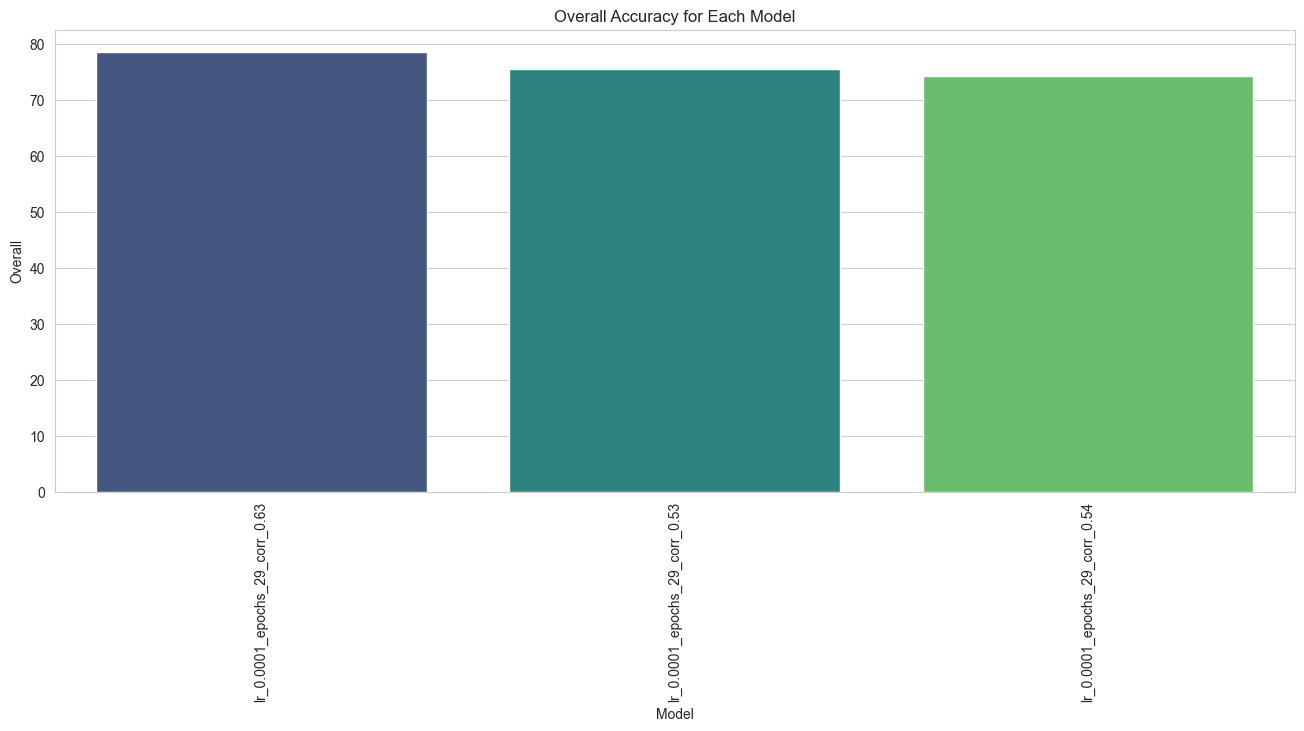

In [37]:
# get reward comparison
reward_comparsion_df = get_reward_comparison(irl_labels)

# Plot irl models comparison
plt.figure(figsize=(16, 6))
sns.barplot(x='Model', y='Overall', data=reward_comparsion_df, palette='viridis')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.title('Overall Accuracy for Each Model')
plt.show()

In [38]:
reward_comparsion_df

,Model,Overall,true_reward_1,true_reward_0
0,lr_0.0001_epochs_29_corr_0.63,78.65,28.55,50.10
1,lr_0.0001_epochs_29_corr_0.53,75.50,24.75,50.75
2,lr_0.0001_epochs_29_corr_0.54,74.35,22.65,51.70


In [39]:
correlation_df

,Column,Correlation
0,lr_0.0001_epochs_29_corr_0.63,0.674499
1,lr_0.0001_epochs_29_corr_0.53,0.513810
2,lr_0.0001_epochs_29_corr_0.54,0.554905
3,pre_irl_reward,-0.052058


In [12]:
# function to plot confusion matrix
def plot_conf_matrix(cm, true_reward_labels, savefig=None):
    label_mapping = {0: 'non-toxic', 1: 'toxic'}
    # mapped_labels = pd.Series(true_reward_labels).map(label_mapping)
    df_cm = pd.DataFrame(cm, 
                         index=[label_mapping[0], label_mapping[1]], 
                         columns=[label_mapping[0], label_mapping[1]])
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 18})
    print(savefig)
    model = re.findall(r'pythia-(.*?)_', savefig) if savefig else []
    plt.title(f'{model[0] if len(model) != 0 else ""} IRL Model Confusion Matrix', size=24)
    plt.xlabel('Predicted', size=22)
    plt.ylabel('True', size=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    if savefig:
        plt.tight_layout()
        plt.savefig(f'plots/irl/conf_matrix_{savefig}.pdf', dpi=600, transparent=True)
    plt.show()

# function to show confusion matrices for all models that have accuracy > acc_thresh and f1 > f1_thresh
def show_conf_matrices(irl_labels, acc_thresh=0.6, f1_thresh=0.6, savefig=False):
    true_reward_labels = irl_labels['true_reward']
    print("Non-Toxic Labels: ", len([x for x in true_reward_labels if x==0]))
    print("Toxic Labels: ", len([x for x in true_reward_labels if x==1]))

    for irl_model in list(irl_labels.keys()):   
        irl_reward_labels = irl_labels[irl_model]

        acc = accuracy_score(true_reward_labels, irl_reward_labels)
        f1 = f1_score(true_reward_labels, irl_reward_labels)

        if acc > acc_thresh and f1 > f1_thresh:
            print("\nModel: ", irl_model)
            print("Accuracy:  ", acc)
            print("F1-Score:  ", f1)
            title = f"{irl_model.split('learned_rm_EleutherAI-')[-1].removesuffix('.pt')}_acc_{acc:.2f}_f1_{f1:.2f}" if savefig else None
            plot_conf_matrix(confusion_matrix(true_reward_labels, irl_reward_labels), true_reward_labels, savefig=title)

## Plot Results

In [13]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("deep")

plt.rcParams.update({
    "font.family": 'sans-serif'
})

In [14]:
# Function to extract the number of epochs from the key
def get_identifier(key, identifier):
    if identifier == 'epochs':
        match = re.search(r'(\d+)_epochs', key)
    elif identifier == 'rirl':
        match = re.search(r'_repeated_(\d+)', key)
    return int(match.group(1)) if match else 0

In [15]:
def plot_reward_comparison(irl_labels, file_name, plt_type='bar', smooth_window=None, savefig=False):
    # load results
    identifier = 'rirl' if 'rirl' in file_name else 'epochs'
    model = '410m' if '410m' in file_name else '70m'

    # Sort the dictionary by an identifier
    irl_labels_sorted = dict(sorted(irl_labels.items(), key=lambda item: get_identifier(item[0], identifier)))

    reward_comparsion_df = get_reward_comparison(irl_labels_sorted)

    # Plot irl models comparison
    plt.figure(figsize=(18, 10))
    if plt_type == 'bar':
        sns.barplot(x='Model', y='Overall', data=reward_comparsion_df, palette='mako')
    elif plt_type == 'line':
        # rolling window to smooth plot
        if smooth_window:
            reward_comparsion_df['Overall'] = reward_comparsion_df['Overall'].rolling(window=smooth_window).mean()
        sns.lineplot(x='Model', y='Overall', data=reward_comparsion_df, marker='o')
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=90)
    title = f'{model} - Accuracy for {"RIRL" if identifier == "rirl" else ""} IRL Models - {"Smooth" if smooth_window else ""}'
    plt.title(title)
    if savefig:
        plt.tight_layout()
        plt.savefig(f'plots/irl/{model}_accuracy_{identifier}_{file_name.removesuffix(".json")}{"_smooth" if smooth_window else ""}.png')
    else:
        plt.show()

In [16]:
def get_correlations(irl_labels):
    corr = {}
    irl_labels_list = list(irl_labels.keys())
    for model in irl_labels_list:
        if model.endswith('.pt'):
            corr[model] = float(re.findall(r'corr_(.*?).pt', model)[0])
    return corr

### 70m IRL models saved at each epoch for 30 epochs

/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_75458/1721185016.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Overall', data=reward_comparsion_df, palette='mako')


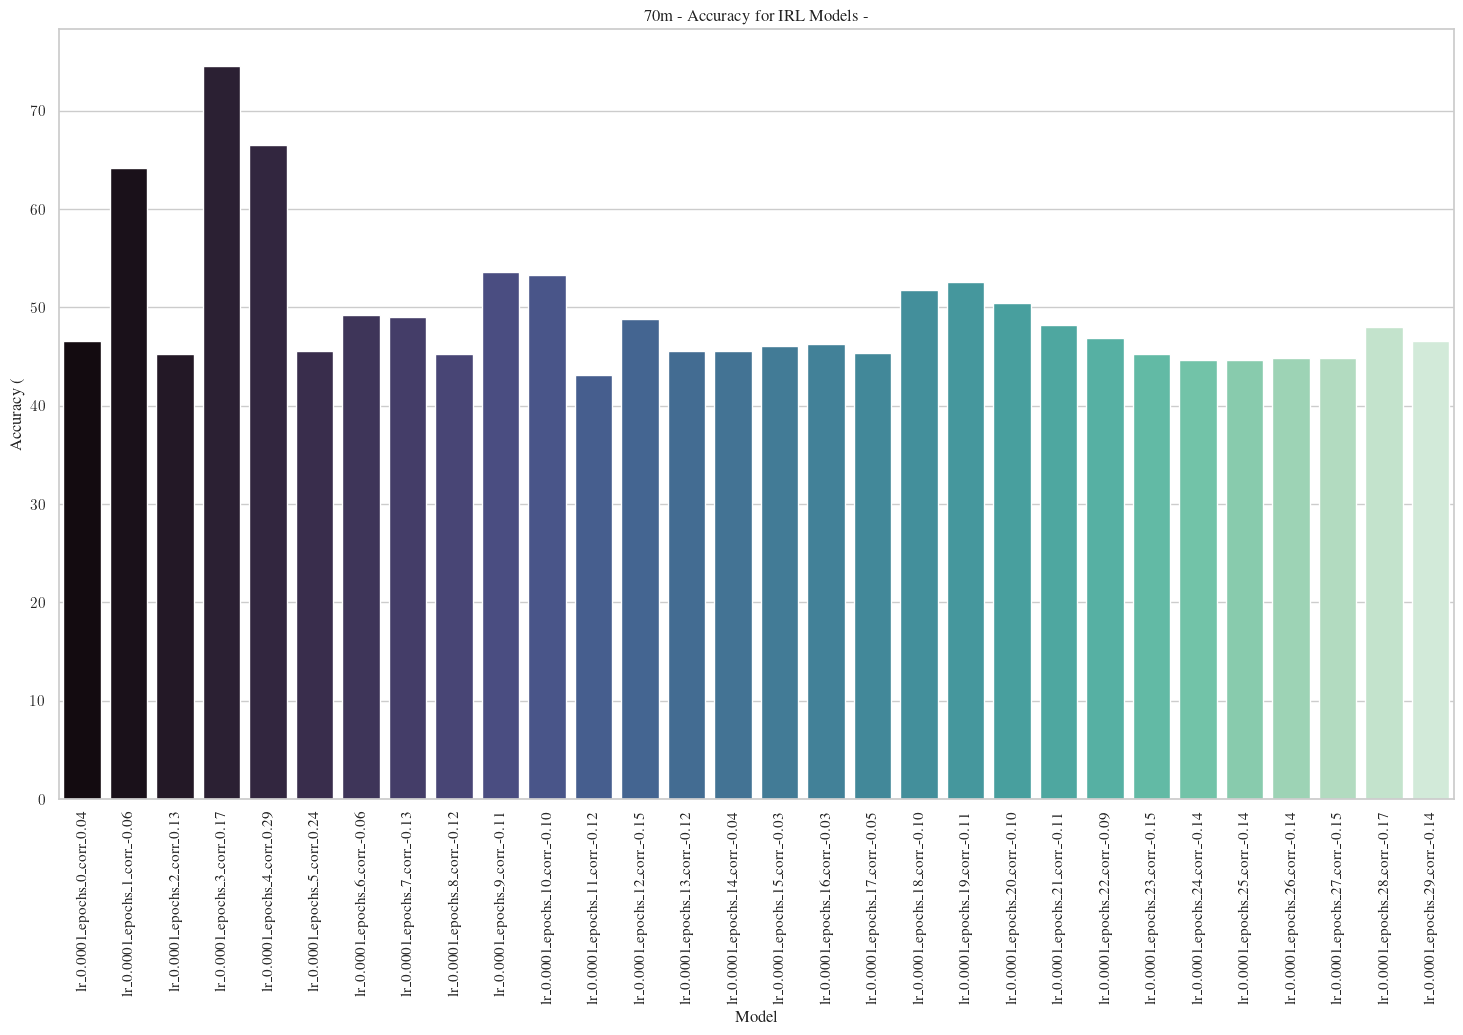

In [237]:
# load results
file_name = 'irl_labels_70m_epochs_1_30.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='bar', savefig=False)

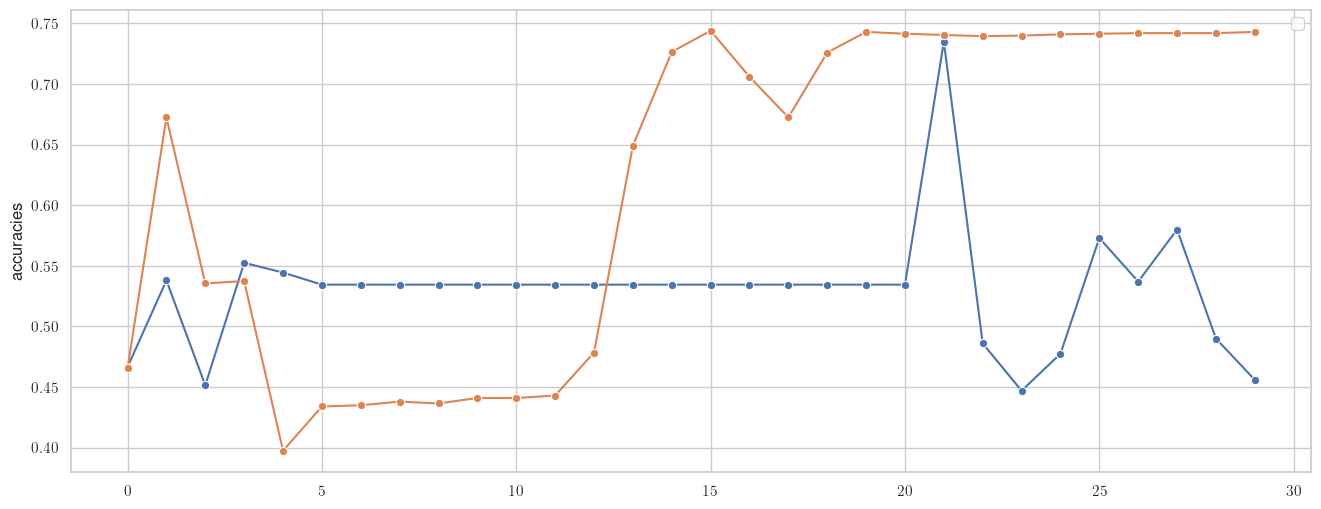

In [143]:
# plot multiple runs on the same plot for comparison, based on a  pattern:
pattern = 'results/irl/loss_corr/results_30_epochs_lr_0.0001_jaredjoss-jigsaw-long-2000_70m_ss_100_acc_*.json'
files = glob.glob(pattern)
plt.figure(figsize=(16, 6))
for file in files:
    df = pd.read_json(file)
    sns.lineplot(data=df['accuracies'], marker='o', label=file.split('_')[-1].removesuffix('.json'))
plt.legend('')

In [19]:
# show_conf_matrices(irl_labels, acc_thresh=0.65, f1_thresh=0.65, savefig=False)

Correlation between accuracy and correlation  0.48828999317199284


/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_75458/3551594243.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Overall', data=reward_comparsion_df, palette='deep')


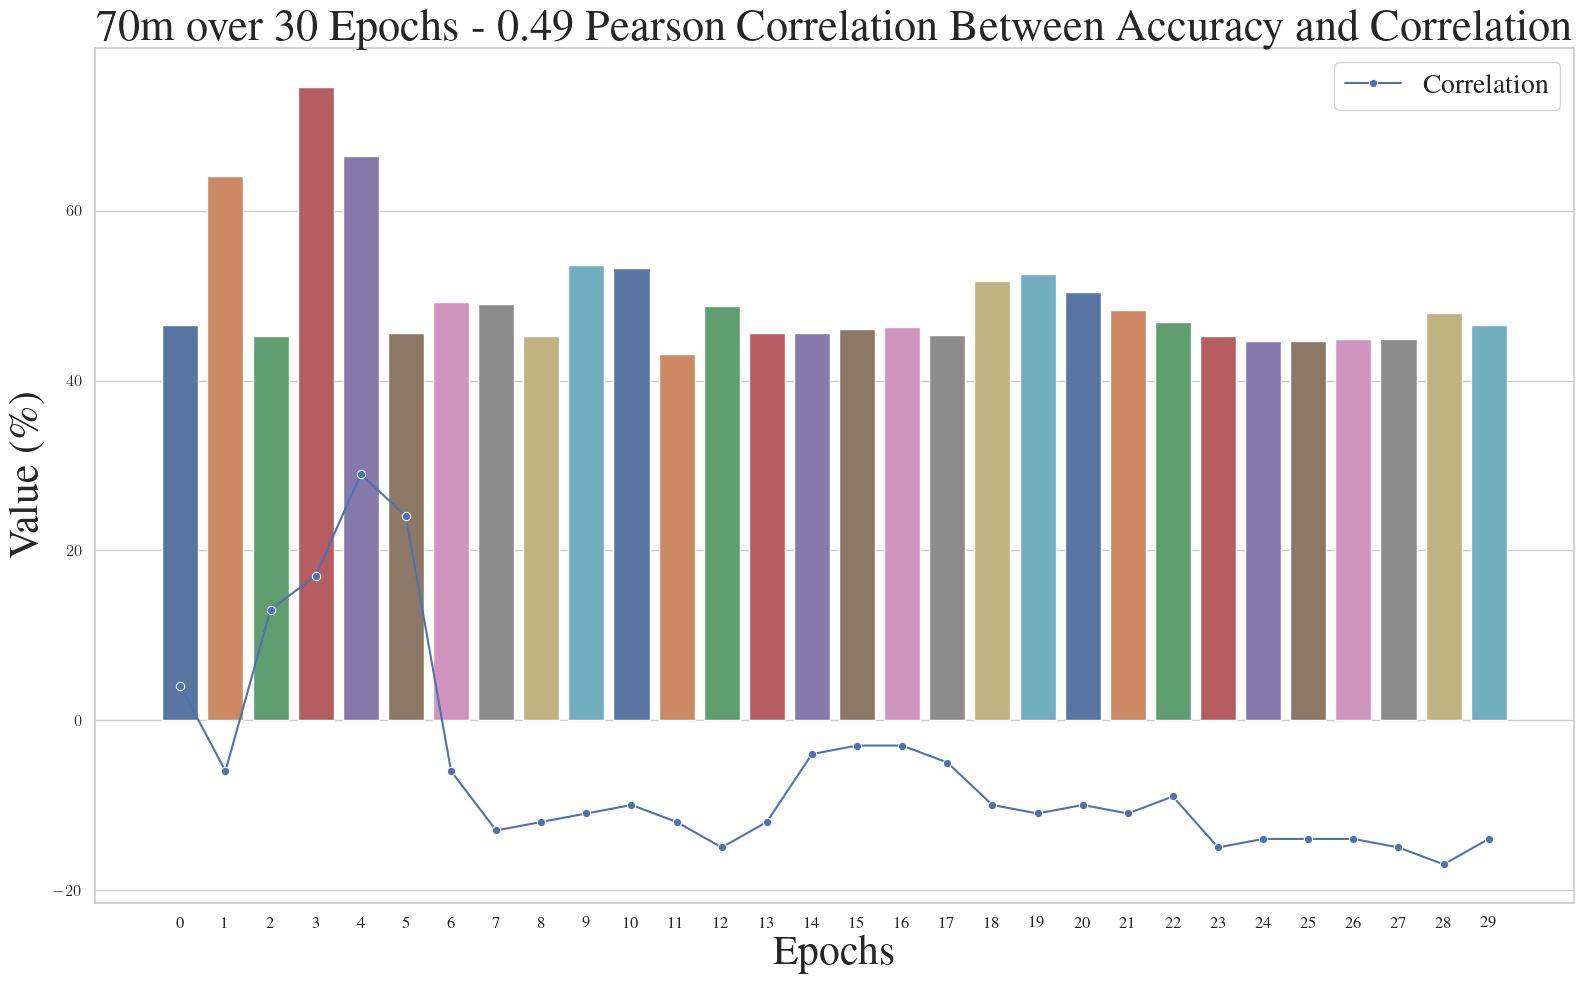

In [250]:
# correlation and accuracy analysis
irl_labels_sorted = dict(sorted(irl_labels.items(), key=lambda item: get_identifier(item[0], 'epochs')))
reward_comparsion_df = get_reward_comparison(irl_labels_sorted)[['Model', 'Overall']]
corrs = {construct_name(k): v for k, v in get_correlations(irl_labels_sorted).items()}
reward_comparsion_df['Correlation'] = reward_comparsion_df['Model'].map(corrs) * 100
reward_comparsion_df['Model'] = reward_comparsion_df['Model'].apply(lambda x: re.findall(r'epochs_(.*?)_', x)[0])

# calculate correlation
correlation = np.corrcoef(reward_comparsion_df['Overall'].tolist(), reward_comparsion_df['Correlation'].tolist())                        
print("Correlation between accuracy and correlation ", correlation[0,1]) 

# plot correlation and accuracy
plt.figure(figsize=(16, 10))
# sns.lineplot(x='Model', y='Overall', data=reward_comparsion_df, marker='o', label='Accuracy')
sns.barplot(x='Model', y='Overall', data=reward_comparsion_df, palette='deep')
sns.lineplot(x='Model', y='Correlation', data=reward_comparsion_df, marker='o', label='Correlation')
plt.xlabel('Epochs', size=30)
plt.ylabel('Value (\%)', size=30)
plt.xticks(rotation=0, size=12)
plt.yticks(size=12)
plt.title(f'70m over 30 Epochs - {correlation[0,1]:.2f} Pearson Correlation Between Accuracy and Correlation', size=32)
plt.legend(fontsize=20)
plt.tight_layout()
# plt.savefig('plots/irl/70m_accuracy_correlation_epochs_1_30.png', dpi=600)
plt.show()

Pearson Correlation between accuracy and correlation  0.48828999317199284
Spearman Correlation between accuracy and correlation  0.34800176157151674


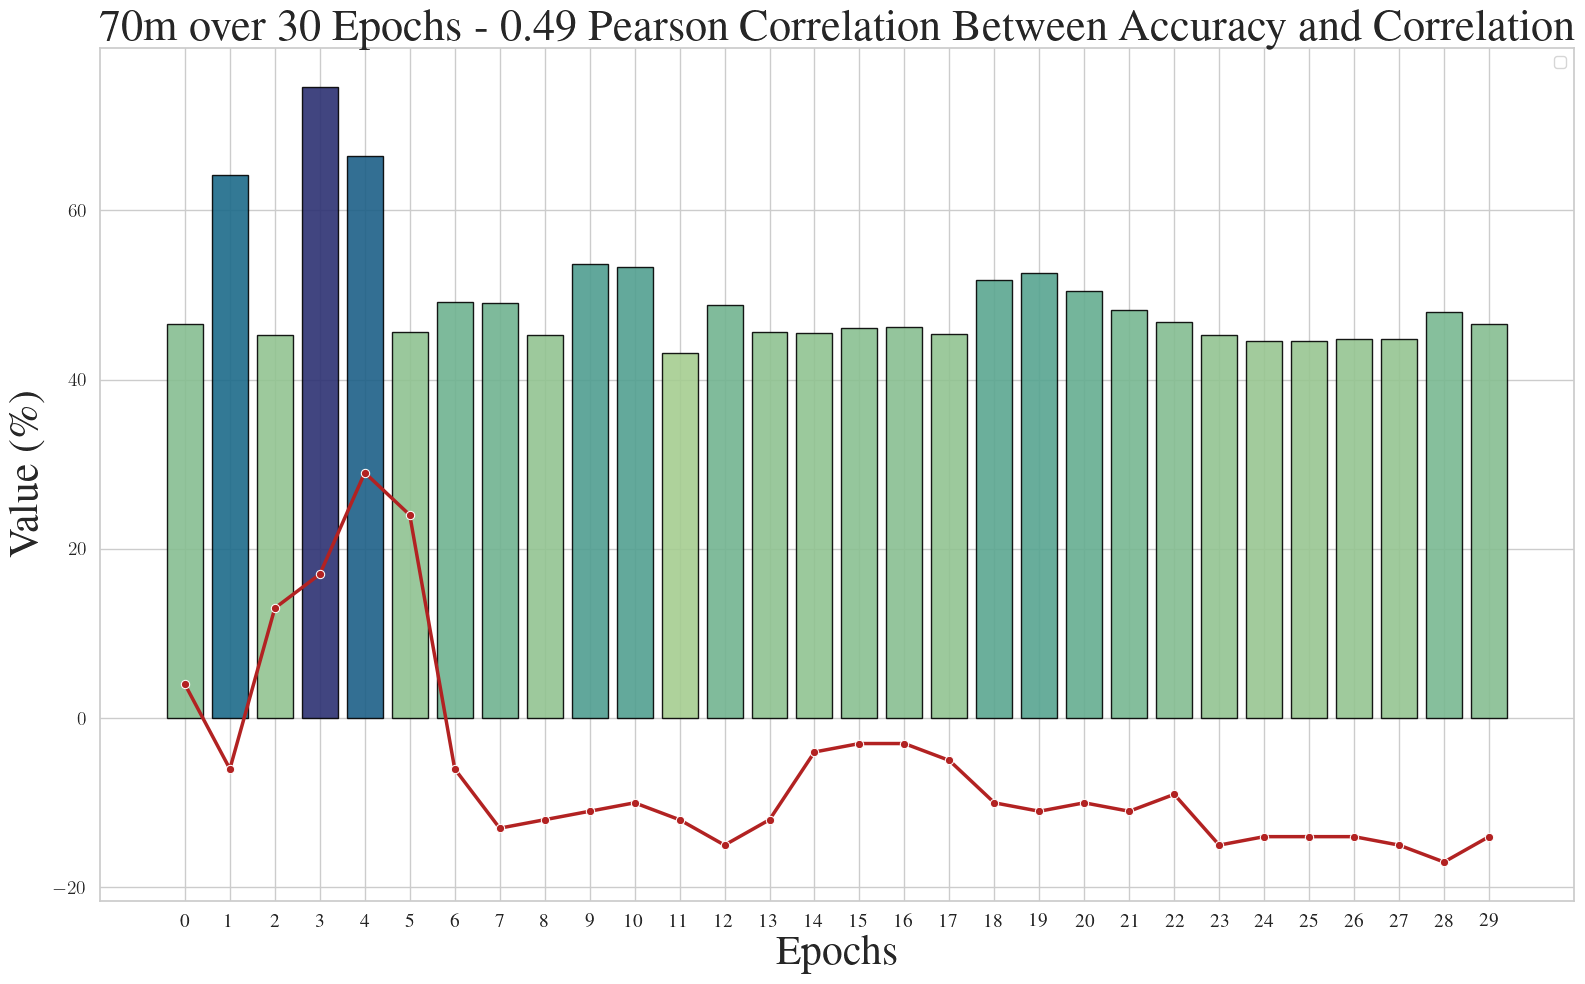

In [285]:
# correlation and accuracy analysis
irl_labels_sorted = dict(sorted(irl_labels.items(), key=lambda item: get_identifier(item[0], 'epochs')))
reward_comparsion_df = get_reward_comparison(irl_labels_sorted)[['Model', 'Overall']]
corrs = {construct_name(k): v for k, v in get_correlations(irl_labels_sorted).items()}
reward_comparsion_df['Correlation'] = reward_comparsion_df['Model'].map(corrs) * 100
reward_comparsion_df['Model'] = reward_comparsion_df['Model'].apply(lambda x: re.findall(r'epochs_(.*?)_', x)[0])

# Calculate correlation
correlation = np.corrcoef(reward_comparsion_df['Overall'].tolist(), reward_comparsion_df['Correlation'].tolist())
print("Pearson Correlation between accuracy and correlation ", correlation[0,1])
print("Spearman Correlation between accuracy and correlation ", stats.spearmanr(reward_comparsion_df['Overall'], reward_comparsion_df['Correlation'])[0])

# Normalize the 'Overall' values for coloring
norm = plt.Normalize(reward_comparsion_df['Overall'].min(), reward_comparsion_df['Overall'].max())
cmap = plt.get_cmap('crest')  # Choose a colormap from matplotlib

# Generate colors for the bars
reward_comparsion_df['Color'] = reward_comparsion_df['Overall'].map(lambda x: cmap(norm(x)))

# Plotting
plt.figure(figsize=(16, 10))

# Plot bars manually
for index, row in reward_comparsion_df.iterrows():
    plt.bar(row['Model'], row['Overall'], color=row['Color'], edgecolor='black', alpha=0.9)

# Plot the line plot for Correlation values
sns.lineplot(x='Model', y='Correlation', data=reward_comparsion_df, marker='o', color='firebrick', linewidth=2.5, label='Correlation')

plt.xlabel('Epochs', size=30)
plt.ylabel('Value (\%)', size=30)
plt.xticks(rotation=0, size=14)  # Rotated x-axis labels for better readability
plt.yticks(size=14)
plt.title(f'70m over 30 Epochs - {correlation[0,1]:.2f} Pearson Correlation Between Accuracy and Correlation', size=32)
plt.legend('')
# plt.grid(True, linestyle='--', alpha=0.6)  # Adding grid lines for better visual reference

plt.tight_layout()
# plt.savefig('plots/irl/70m_accuracy_correlation_epochs_1_30.png', dpi=600)
plt.show()

In [101]:
# reward comparison
file_name = 'irl_rewards_70m_epochs_1_30.json'
irl_rewards = json.load(open(f'results/irl/labels_rewards/{file_name}'))
irl_rewards = dict(sorted(irl_rewards.items(), key=lambda item: get_identifier(item[0], 'epochs')))

results = reward_metrics(irl_rewards)

### 70m - Various lr and epochs

/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_61746/993854231.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Overall', data=reward_comparsion_df, palette='viridis')


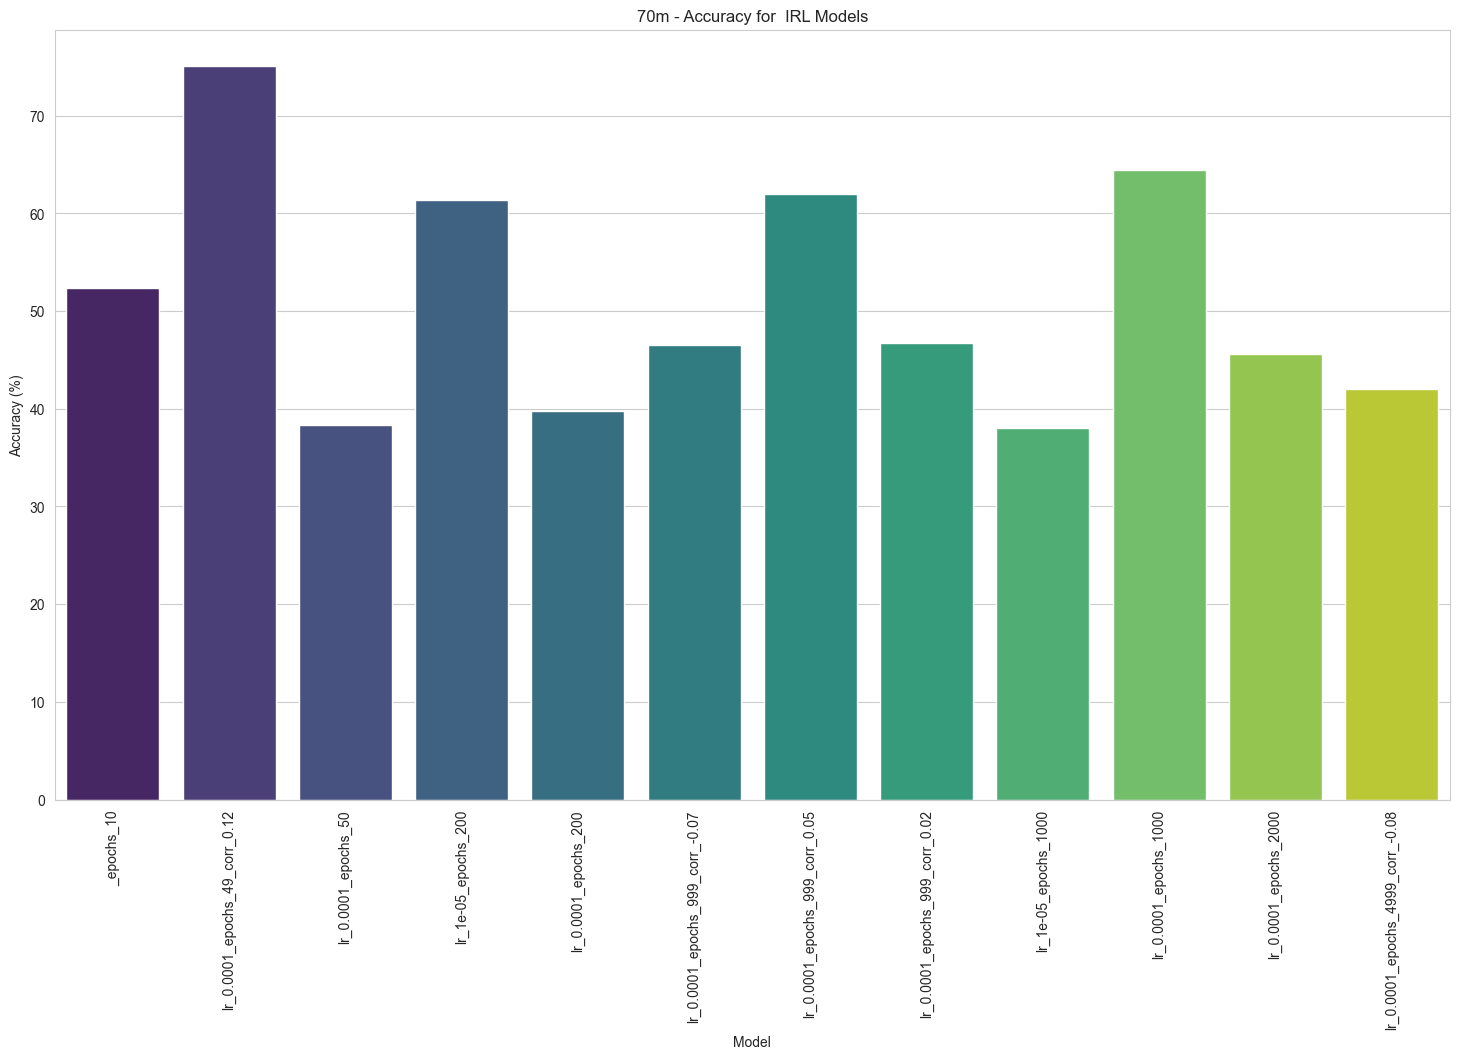

In [34]:
# load results
file_name = 'irl_labels_70m_various_lr_epoch.json'
irl_labels = json.load(open(f'results/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='bar', savefig=False)

### RIRL

#### RIRL - 70m, 1 epoch over 100 repetitions

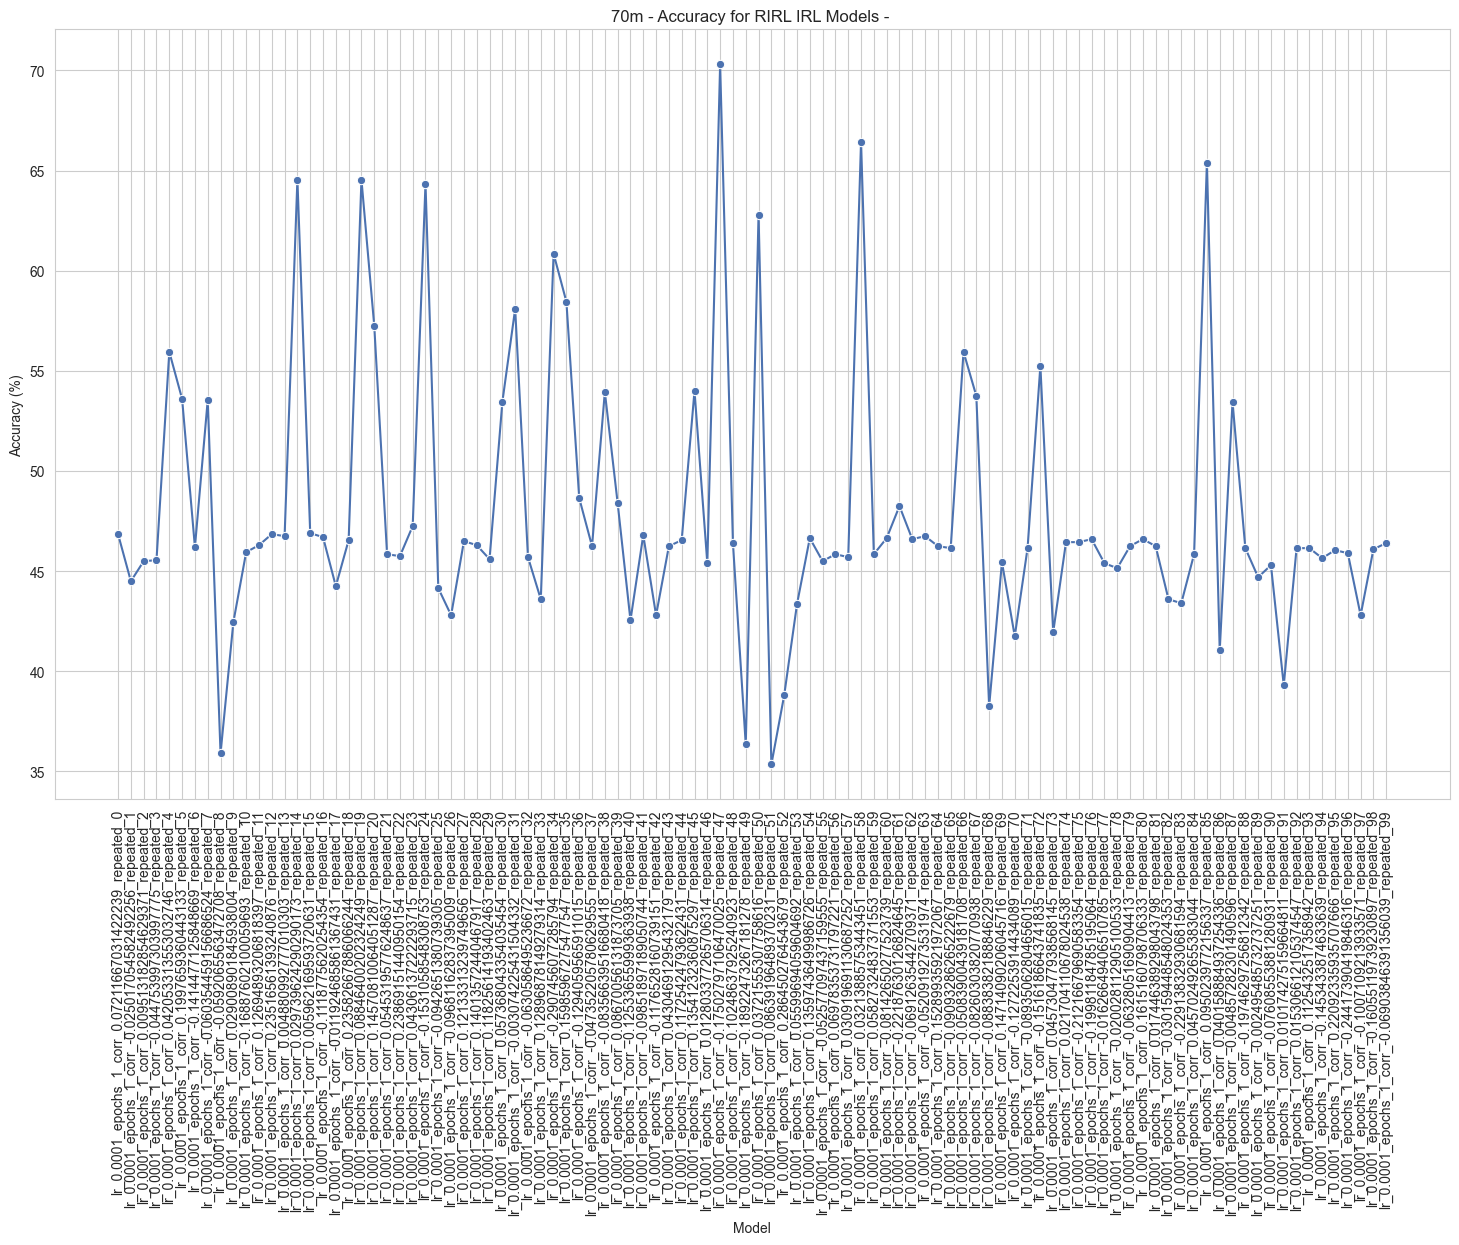

In [56]:
# load results
file_name = 'irl_labels_70m_rirl_1_epoch_100_reps.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=None, savefig=False)

#### RIRL - 70m, 2 epoch over 30 repetitions

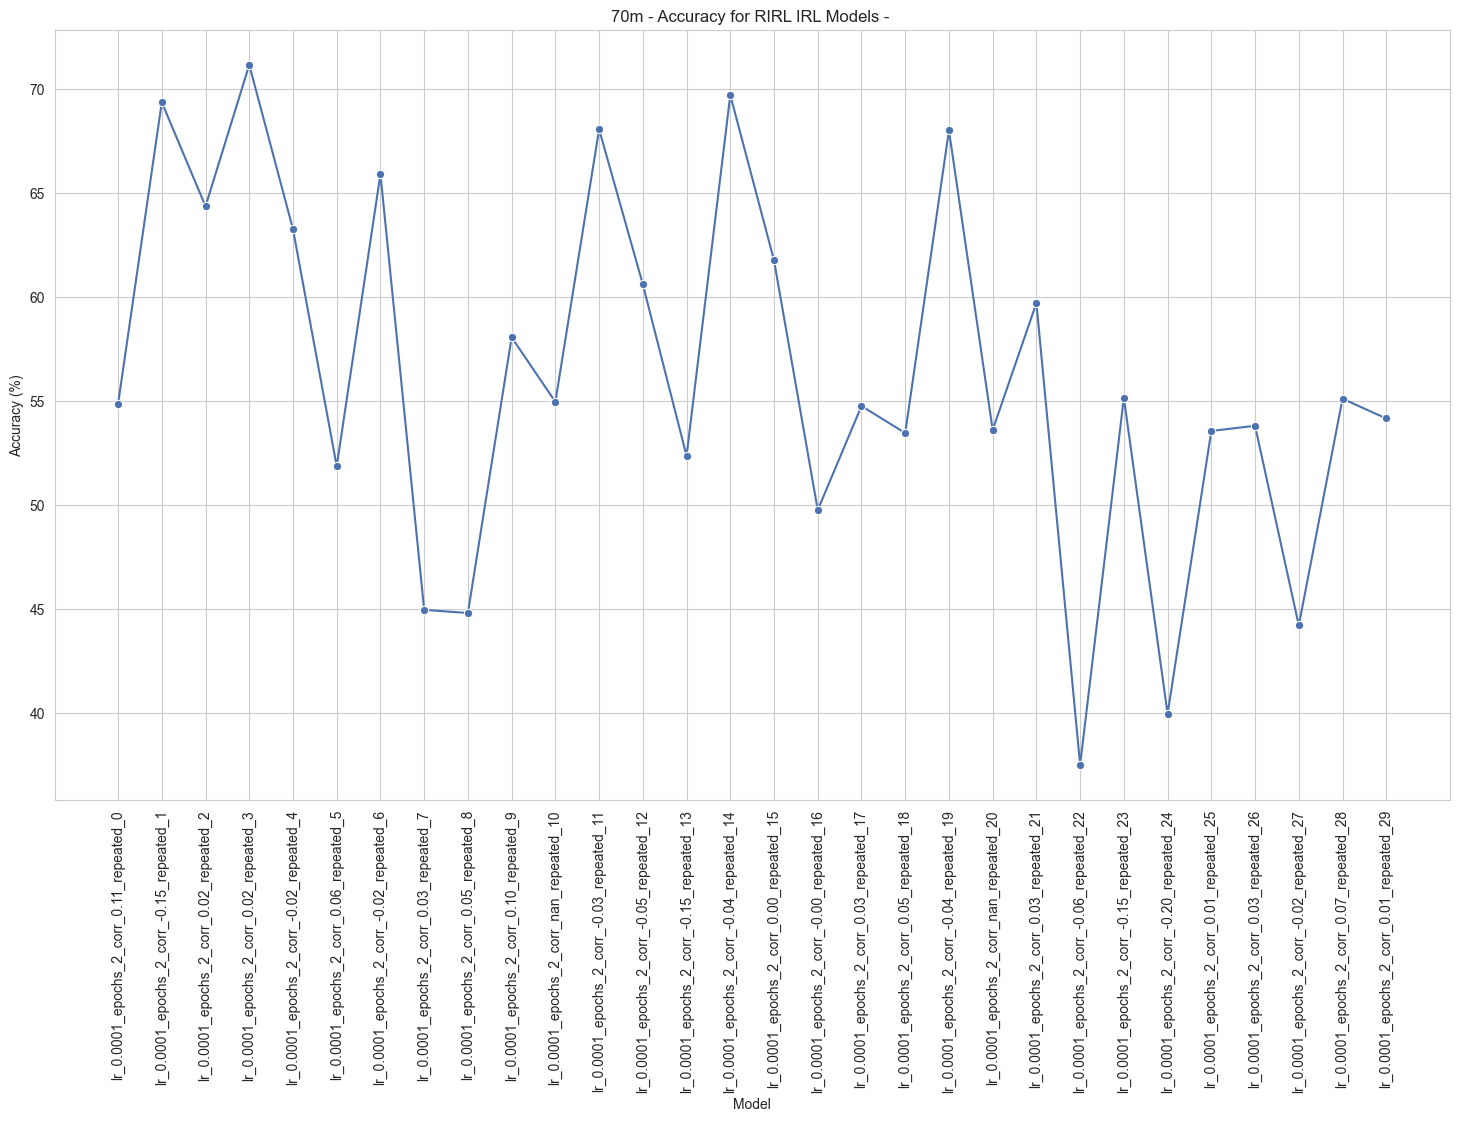

In [57]:
# load results
file_name = 'irl_labels_70m_rirl_2_epoch_30_reps.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=None, savefig=False)

#### RIRL - 70m, 8 epochs over 20 repetitions

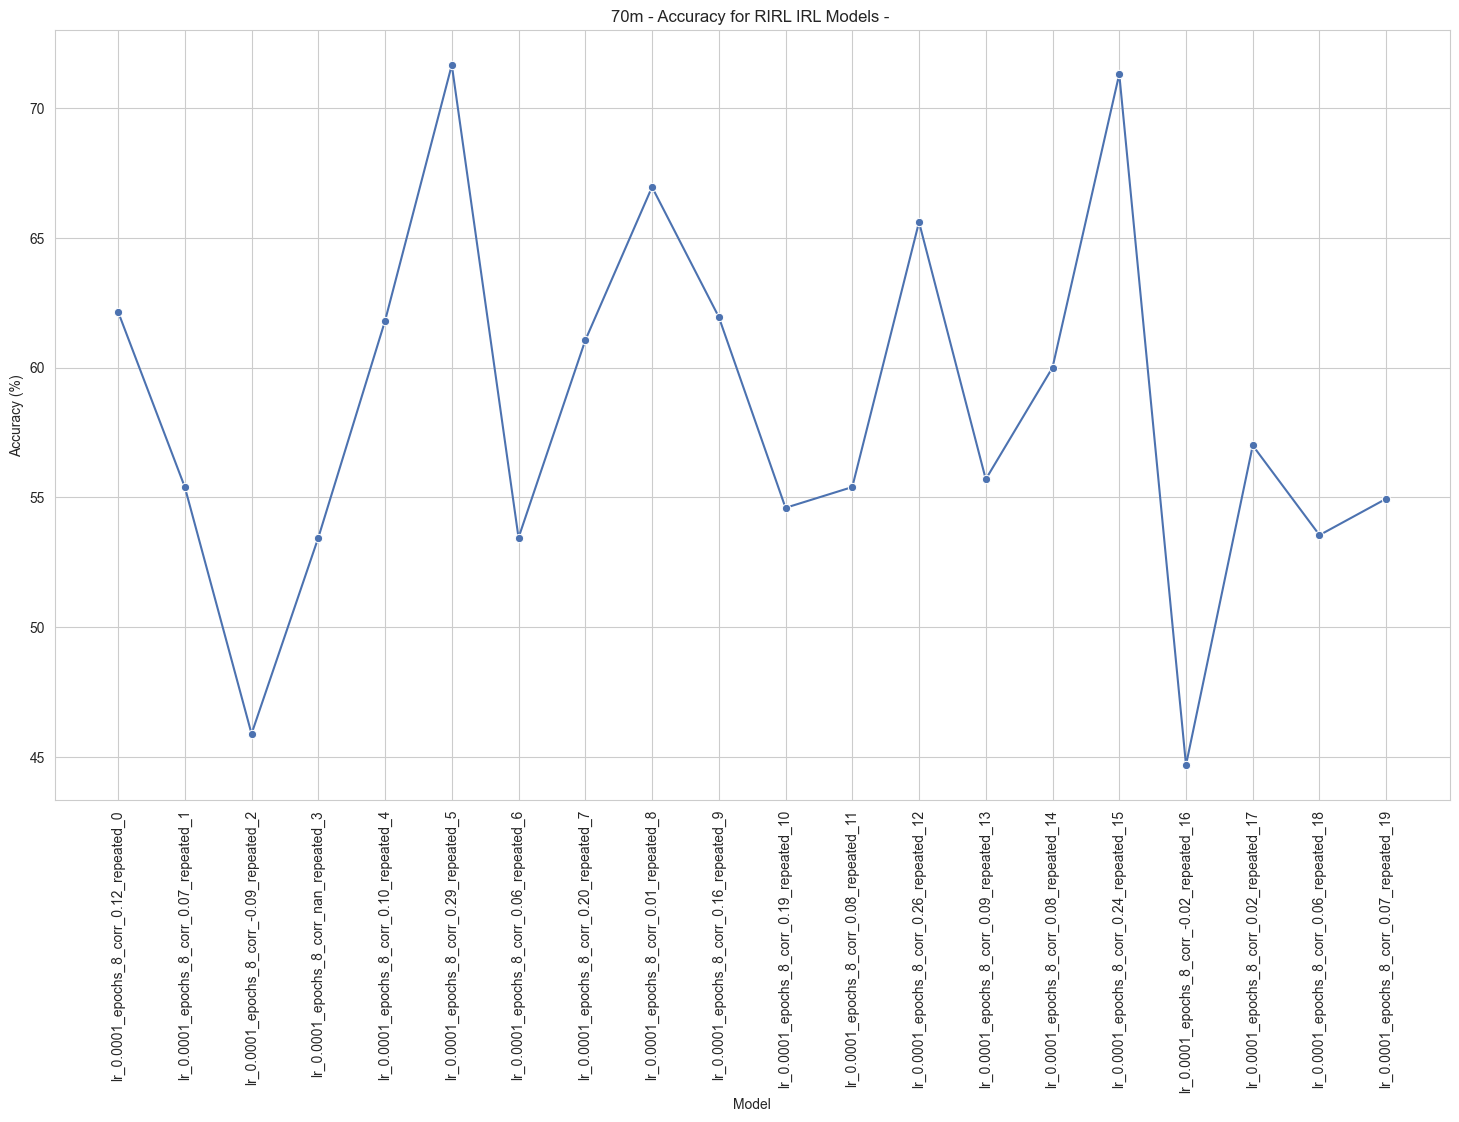

In [55]:
# load results
file_name = 'irl_labels_70m_rirl_8_epochs_20_reps.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=None, savefig=False)

#### RIRL - 70m, 50 epochs over 7 repetitions

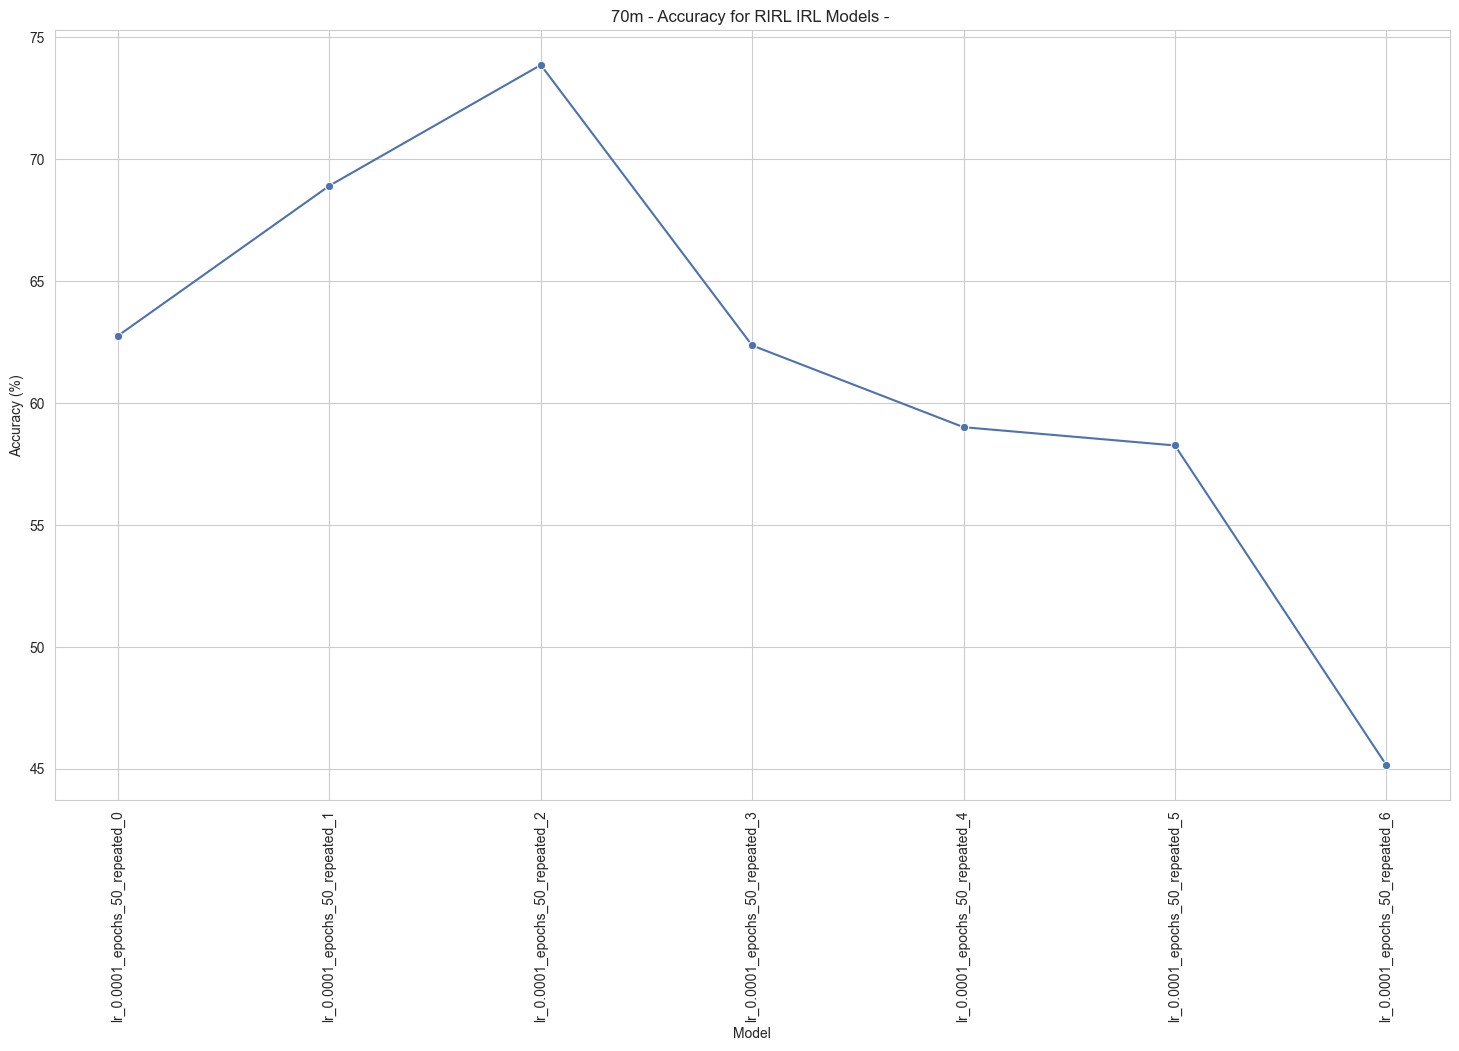

In [54]:
# load results
file_name = 'irl_labels_70m_rirl_50_epochs_lr_0.0001_ss_100.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=None, savefig=False)

#### RIRL - 70m, 10 epochs over 7 repetitions

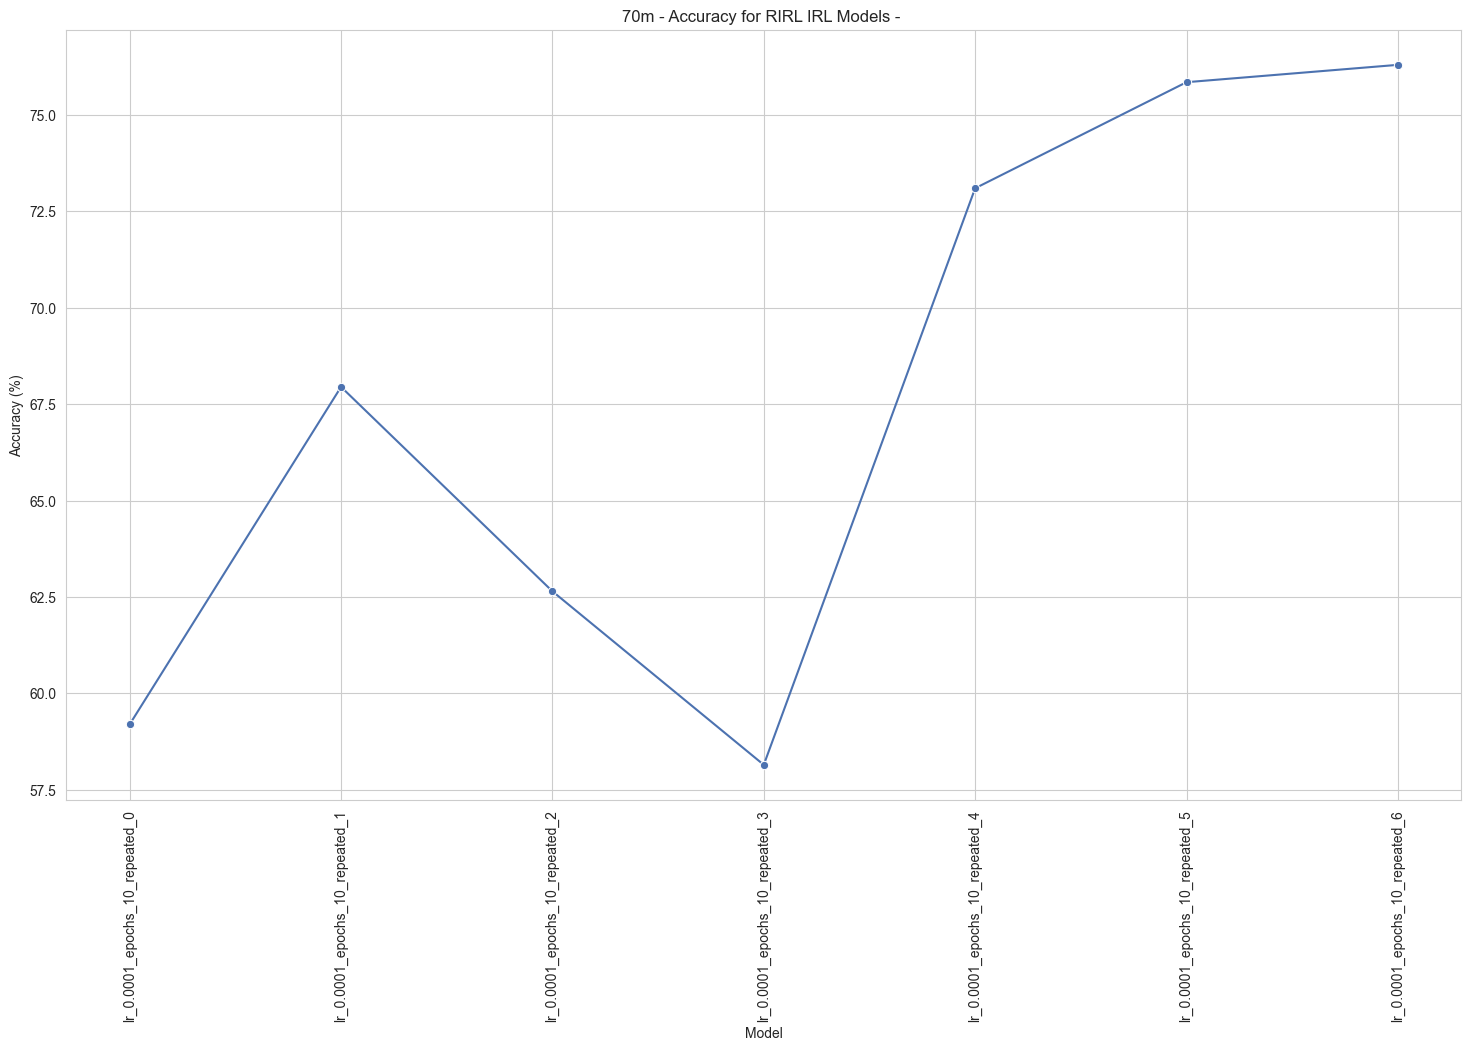

In [53]:
# load results
file_name = 'irl_labels_70m_rirl_10_epochs_lr_0.0001_ss_100.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=None, savefig=False)

#### RIRL - 70m, 10 epochs over 30 reps

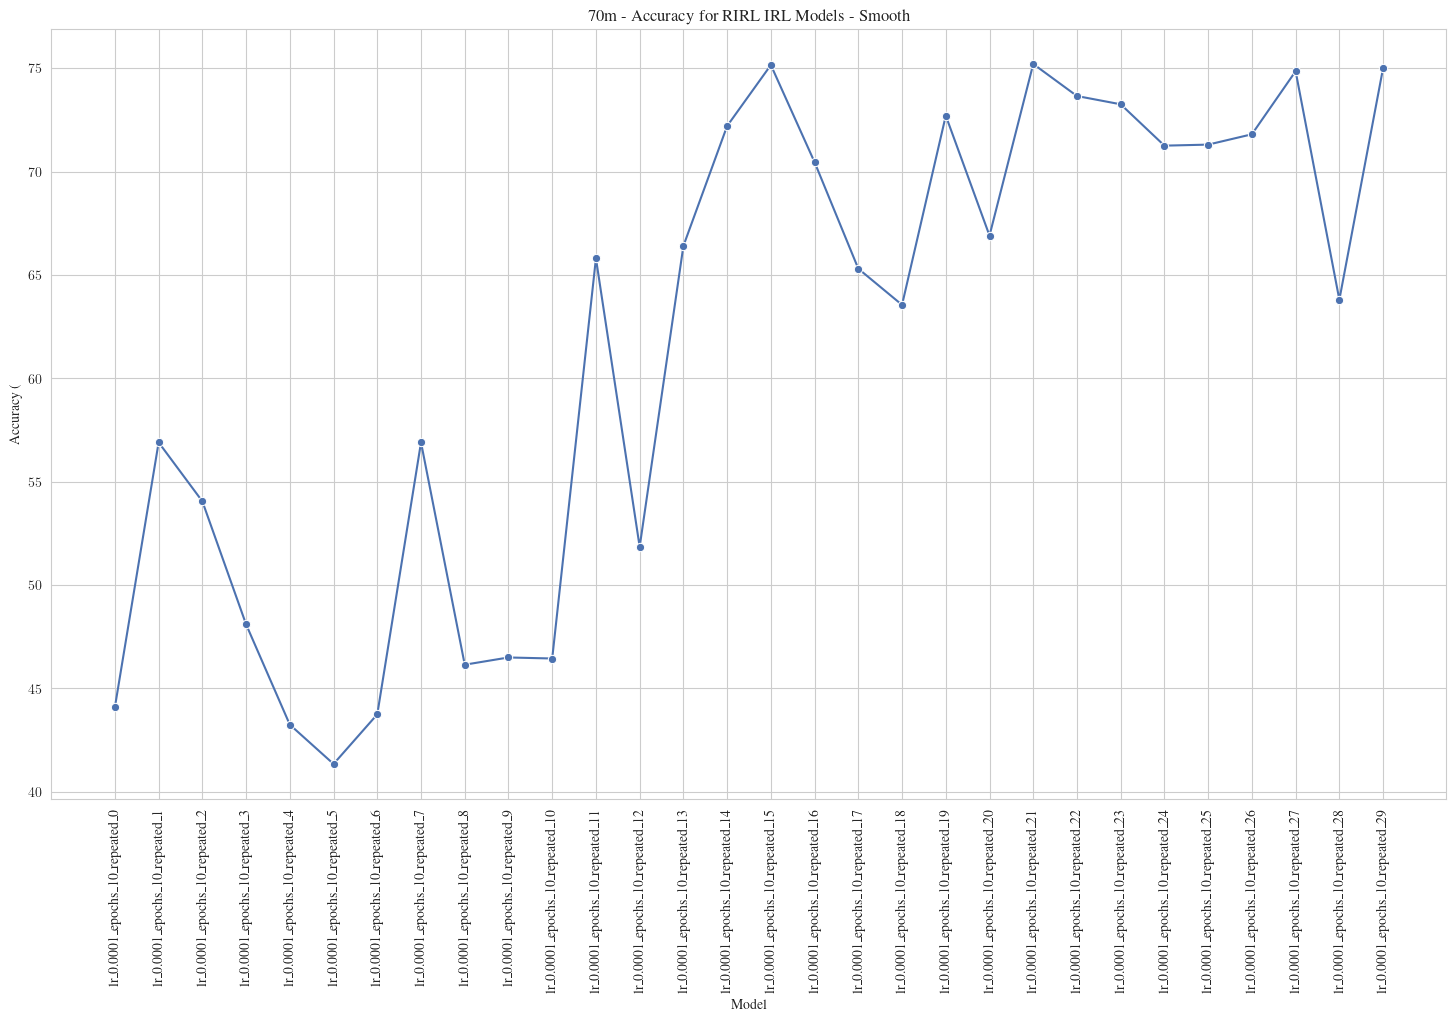

In [102]:
# load results
file_name = '70m_rirl_10_epochs_30_reps_lr_0.0001.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/irl_labels_{file_name}'))
irl_rewards = json.load(open(f'results/irl/labels_rewards/irl_rewards_{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=1, savefig=False)

In [32]:
# correlation analysis - which correlation is best indication for accuacracy?
from scipy import stats

irl_rewards_sorted = dict(sorted(irl_rewards.items(), key=lambda item: get_identifier(item[0], 'rirl')))

true_rewards = irl_rewards_sorted['true_reward']

for key in irl_rewards_sorted.keys():
    if key != 'true_reward':
        learned_rewards = irl_rewards_sorted[key]
        print(key)
        print("Pearson", np.corrcoef(true_rewards, learned_rewards)[0,1])
        print("Spearman", stats.spearmanr(true_rewards, learned_rewards)[0])
        print("Kendall-Tau", stats.kendalltau(true_rewards, learned_rewards)[0])

learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_10_epochs_lr_0.0001_repeated_0_ss_100.pt
Pearson -0.09444495691663975
Spearman 0.23954754801569936
Kendall-Tau 0.1626371031667631
learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_10_epochs_lr_0.0001_repeated_1_ss_100.pt
Pearson 0.1656359117480002
Spearman 0.2970791087584385
Kendall-Tau 0.19927232635775272
learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_10_epochs_lr_0.0001_repeated_2_ss_100.pt
Pearson 0.13804975732187075
Spearman 0.3573273741236471
Kendall-Tau 0.23850514197654074
learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_10_epochs_lr_0.0001_repeated_3_ss_100.pt
Pearson -0.02405673743614806
Spearman -0.010280058265647861
Kendall-Tau -0.005175464260858989
learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_10_epochs_lr_0.0001_repeated_4_ss_100.pt
Pearson -0.130251354583336
Spearman 0.1613225987822999
Kendall-Tau 0.10666574180029303
learned_rm_Eleu

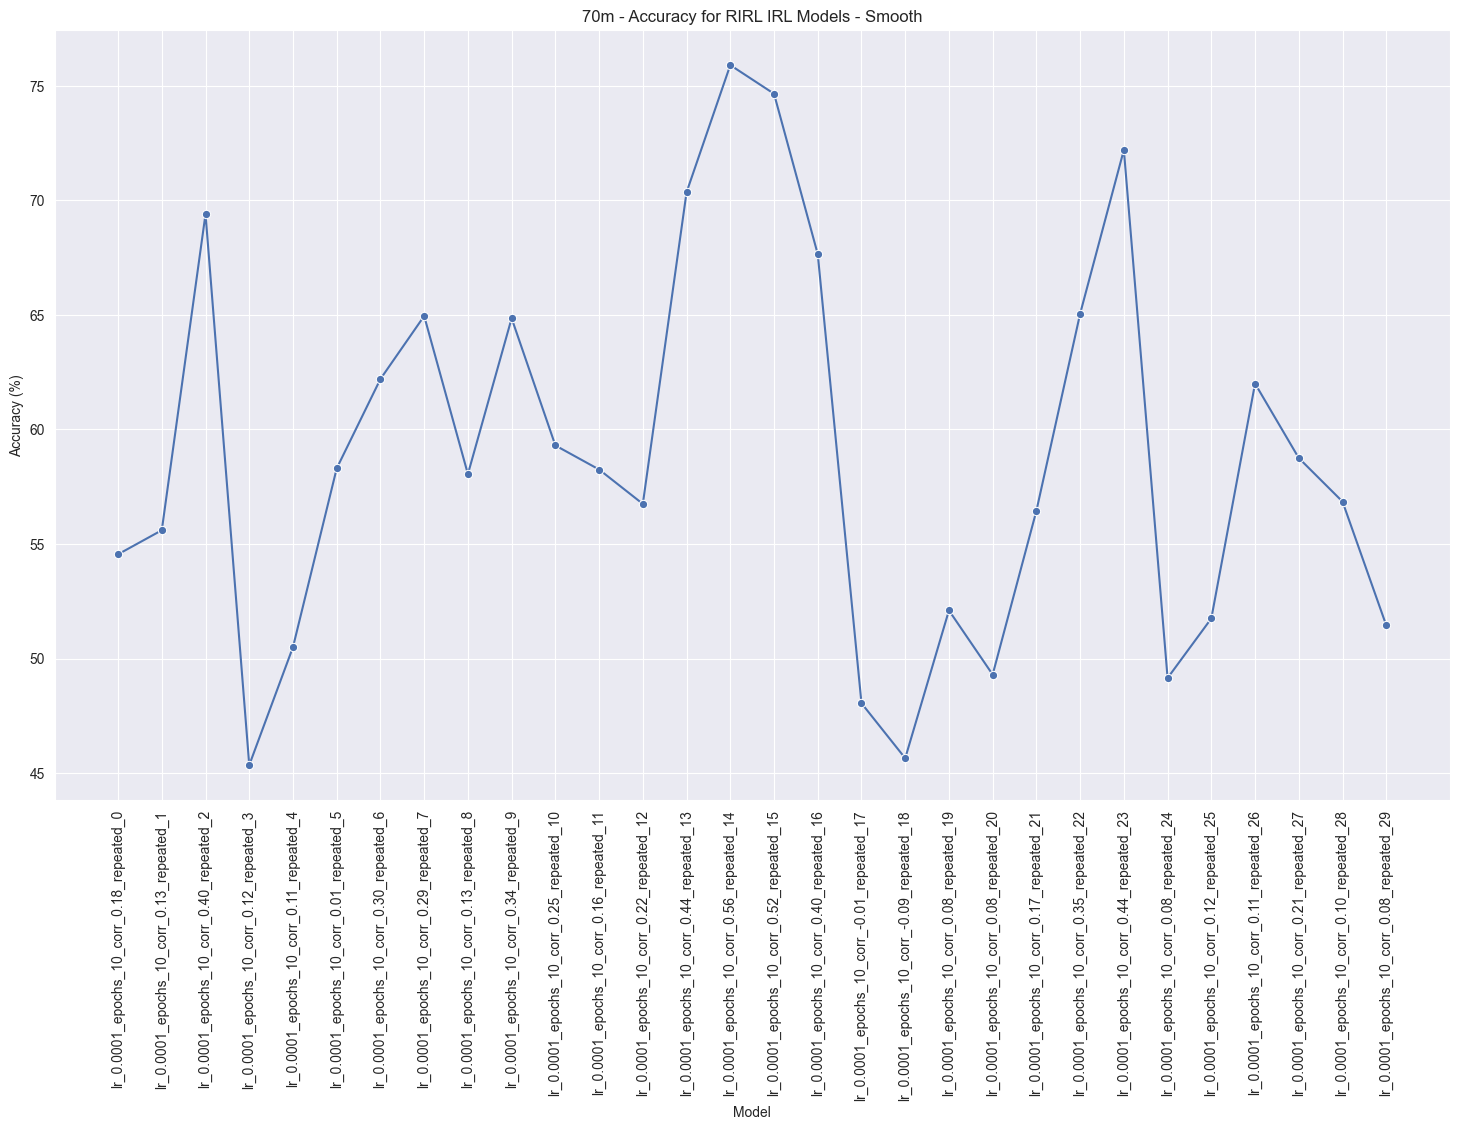

In [80]:
# load results
file_name = 'irl_labels_70m_rirl_10_epochs_30_reps_2.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=1, savefig=False)

#### RIRL - 70m, 10 epochs over 78 reps

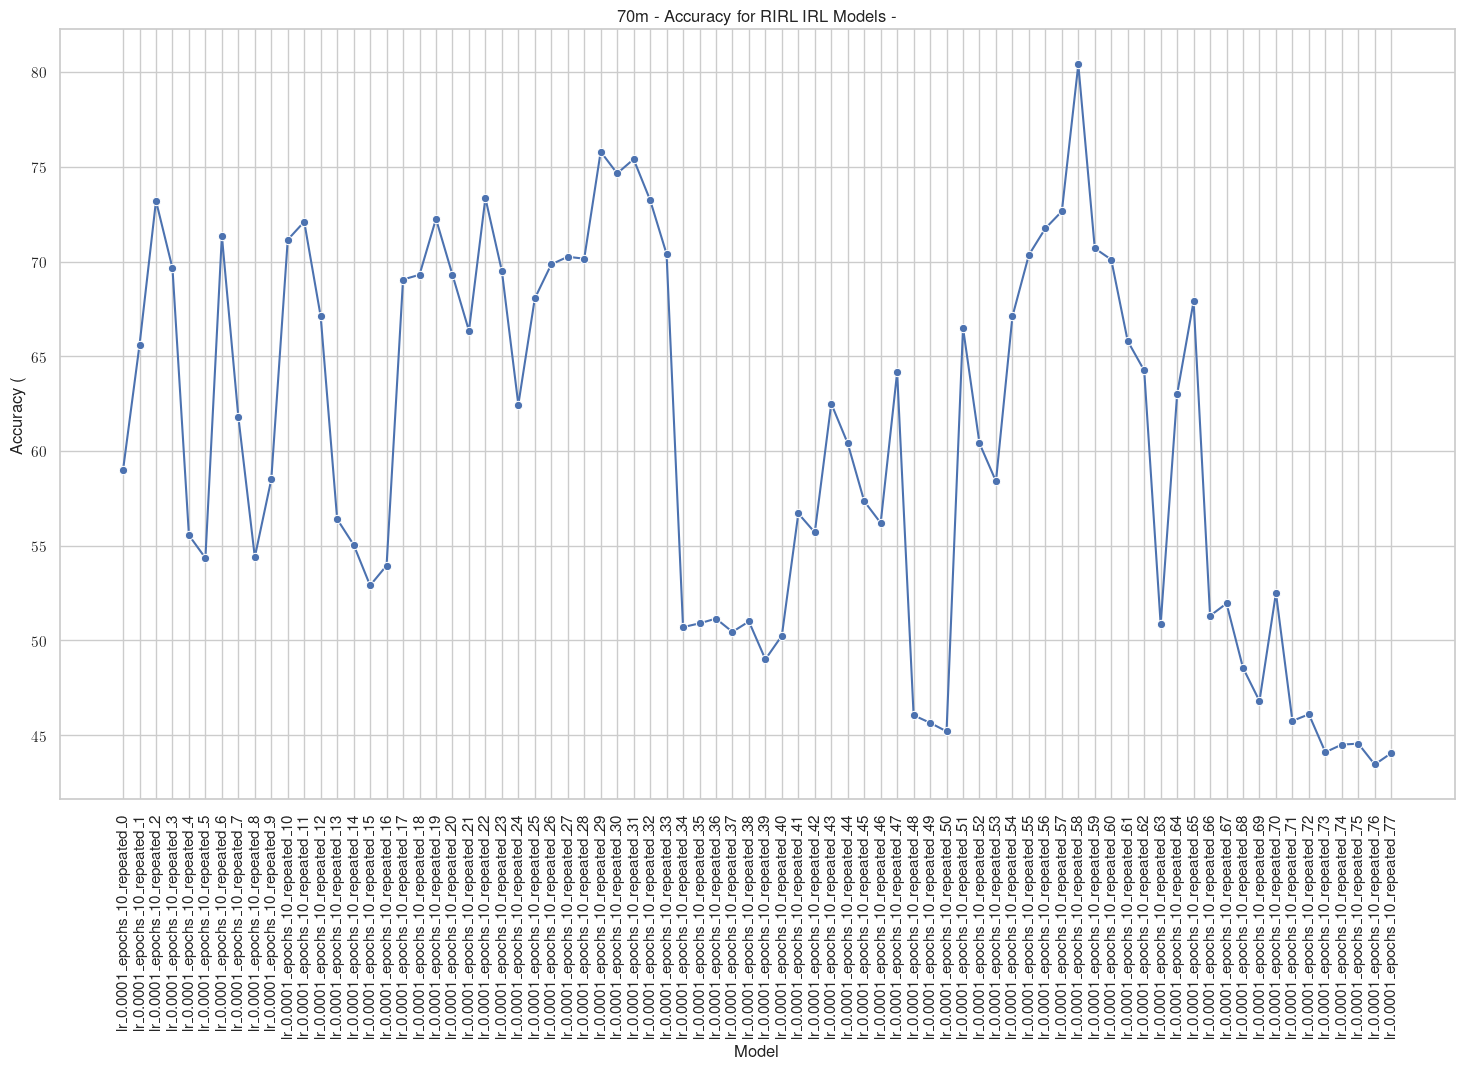

In [190]:
# load results
file_name = 'irl_labels_70m_rirl_10_epoch_78_reps.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=None, savefig=False)

Non-Toxic Labels:  1069
Toxic Labels:  931

Model:  true_reward
Accuracy:   1.0
F1-Score:   1.0
true_reward_acc_1.00_f1_1.00


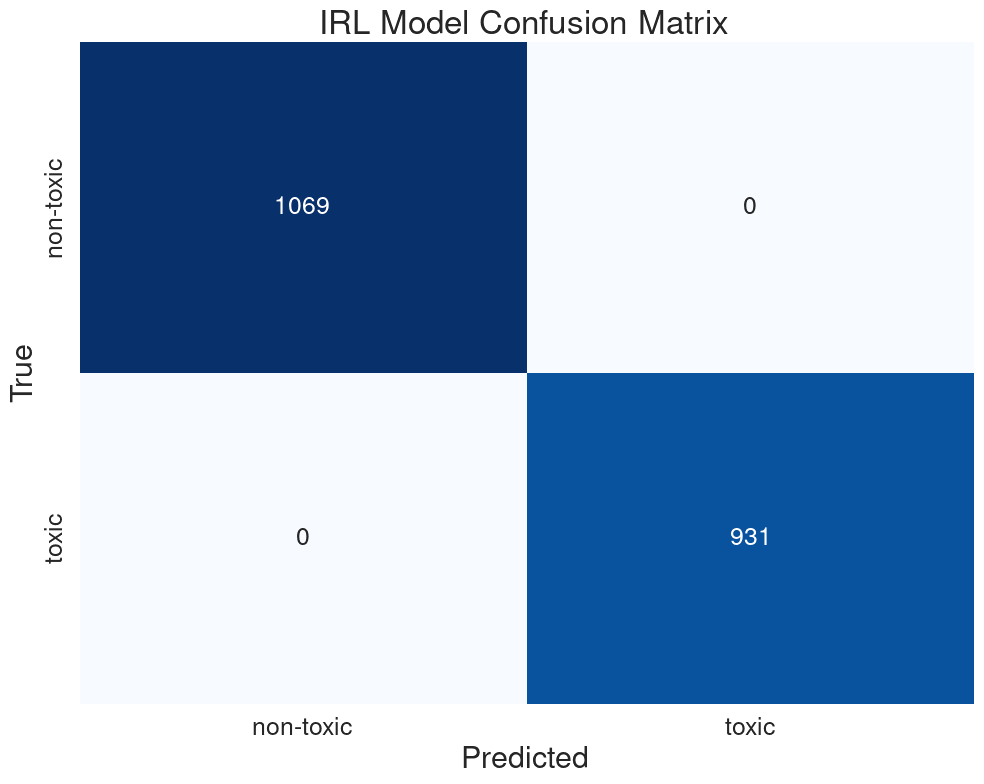


Model:  learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_10_epochs_lr_0.0001_repeated_58_ss_100.pt
Accuracy:   0.804
F1-Score:   0.7839029768467475
pythia-70m_s-nlp-roberta_toxicity_classifier_10_epochs_lr_0.0001_repeated_58_ss_100_acc_0.80_f1_0.78


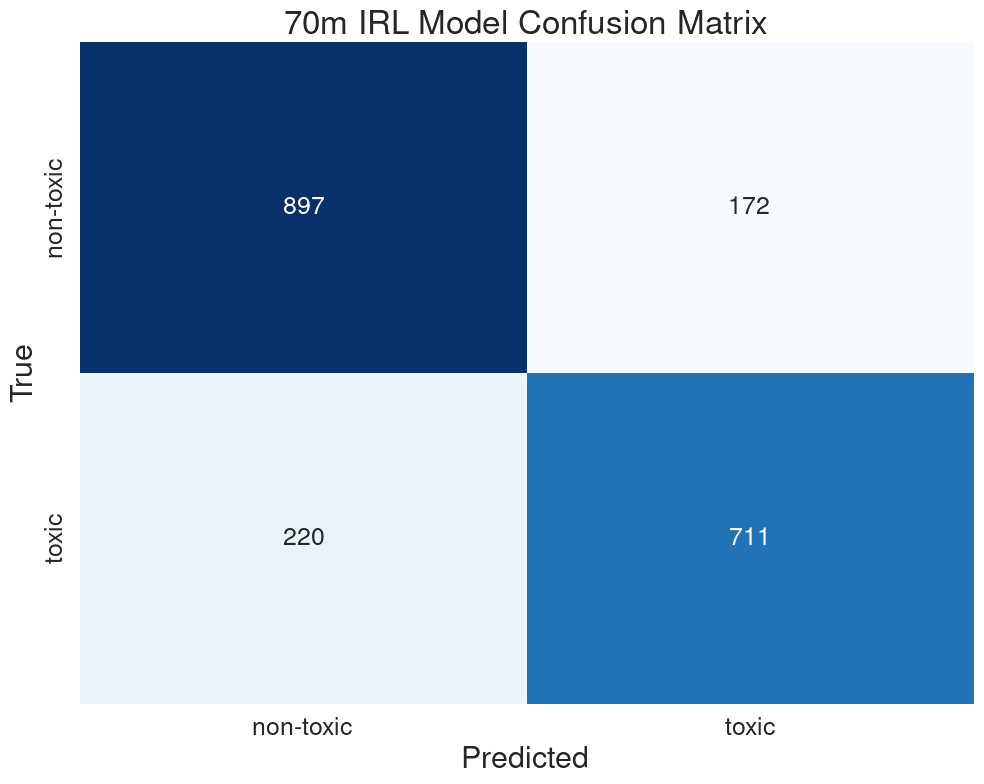

In [191]:
show_conf_matrices(irl_labels, acc_thresh=0.80, f1_thresh=0.75, savefig=True)

#### RIRL - 70m, 10 epochs over 100 reps

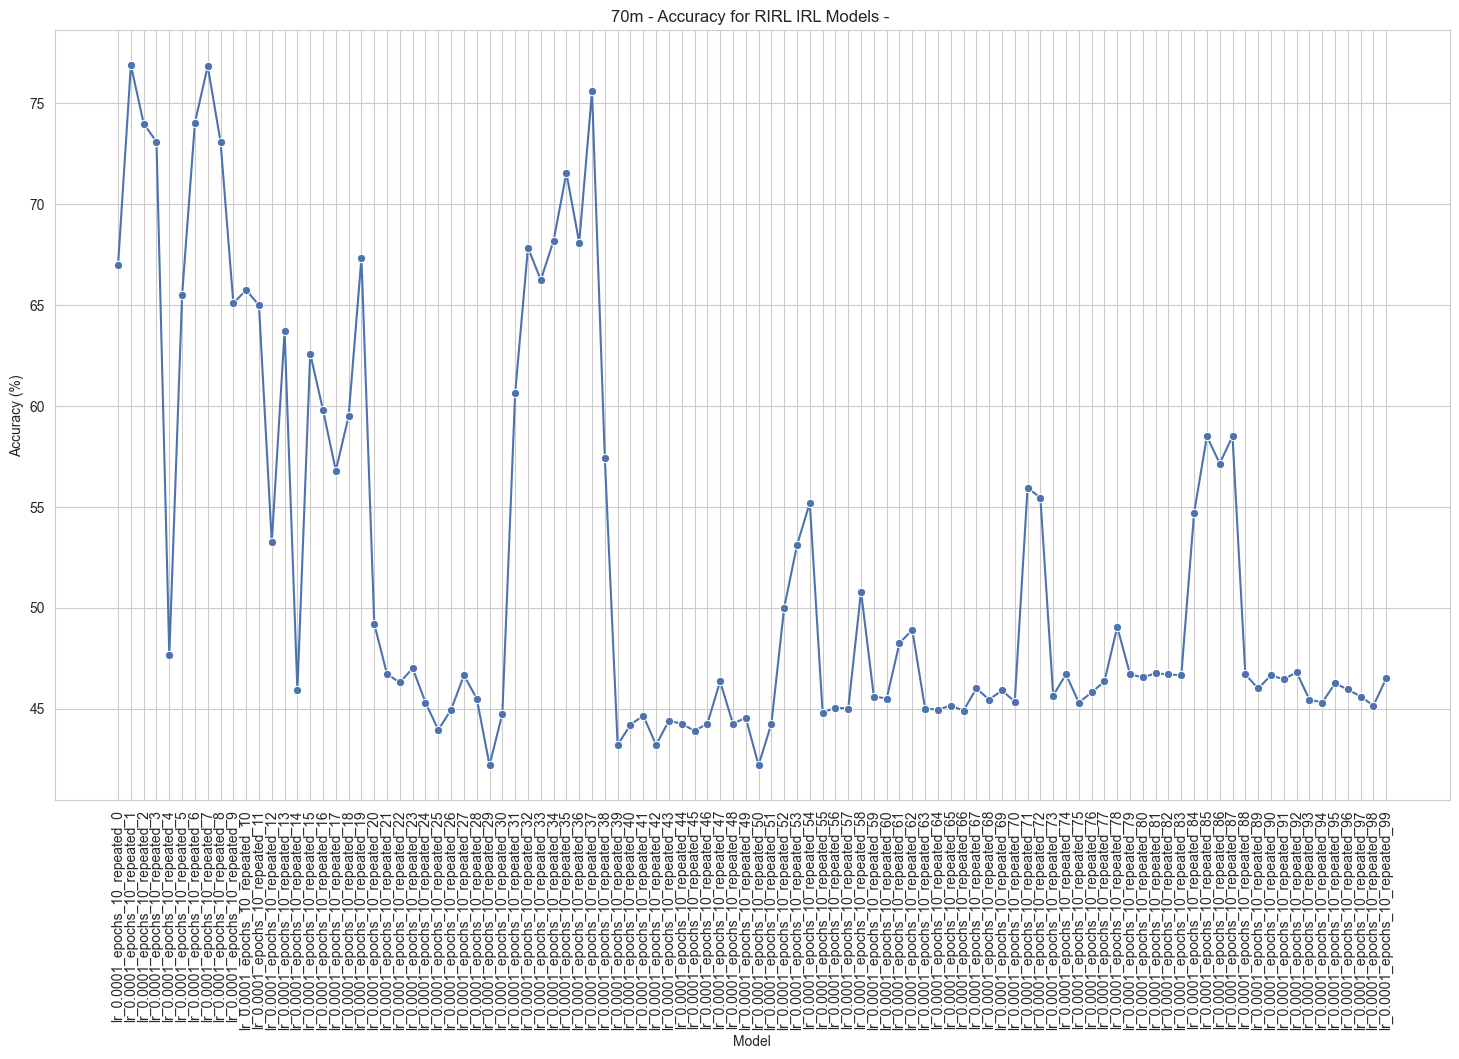

In [60]:
# load results
file_name = 'irl_labels_70m_rirl_10_epochs_100_reps_lr_0.0001.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', savefig=False)

Non-Toxic Labels:  1069
Toxic Labels:  931

Model:  true_reward
Accuracy:   1.0
F1-Score:   1.0


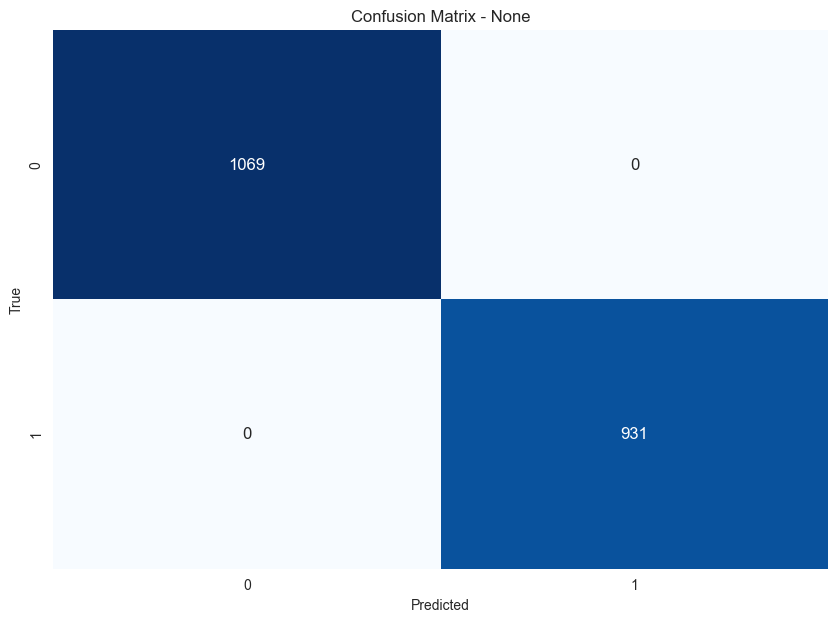


Model:  learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_10_epochs_lr_0.0001_repeated_7_ss_100.pt
Accuracy:   0.7685
F1-Score:   0.7199032062915911


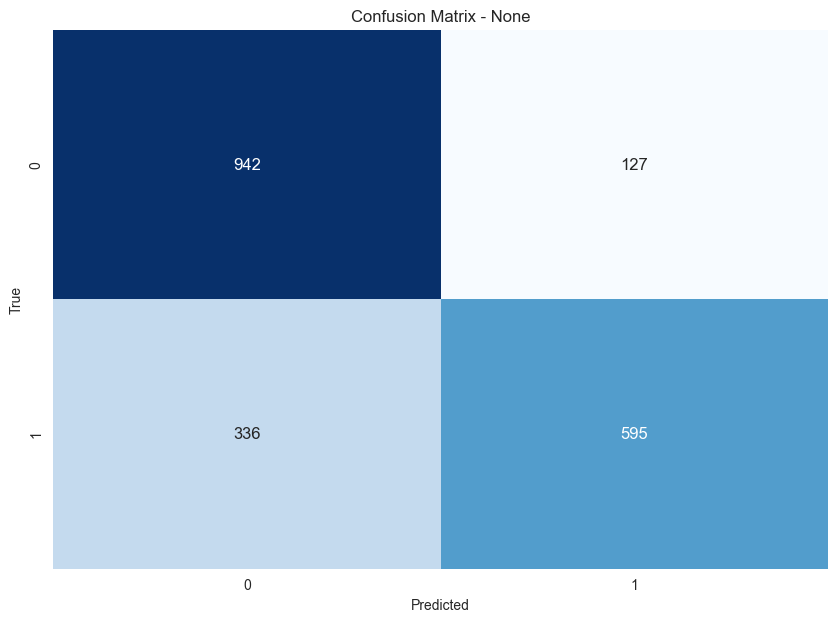


Model:  learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_10_epochs_lr_0.0001_repeated_1_ss_100.pt
Accuracy:   0.769
F1-Score:   0.7087011349306432


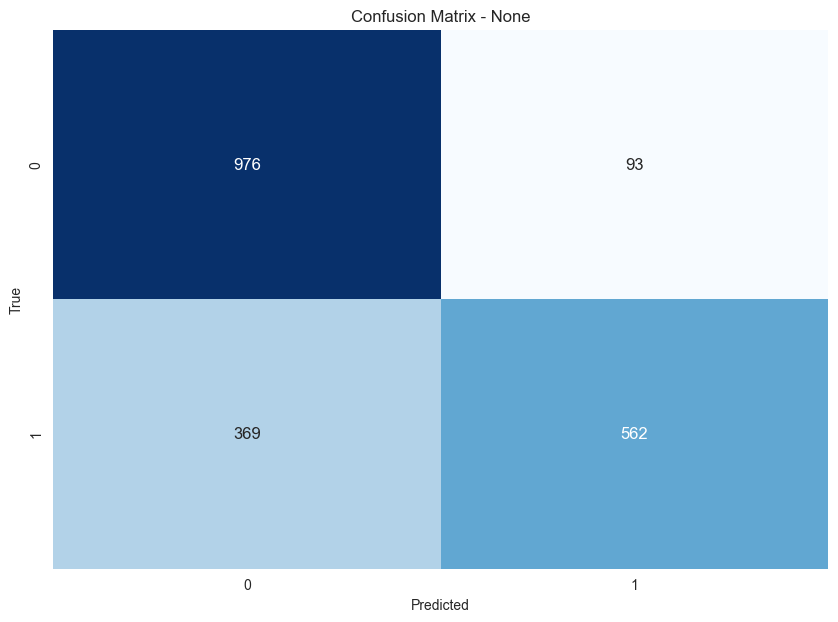


Model:  learned_rm_EleutherAI-pythia-70m_s-nlp-roberta_toxicity_classifier_10_epochs_lr_0.0001_repeated_37_ss_100.pt
Accuracy:   0.756
F1-Score:   0.7192174913693902


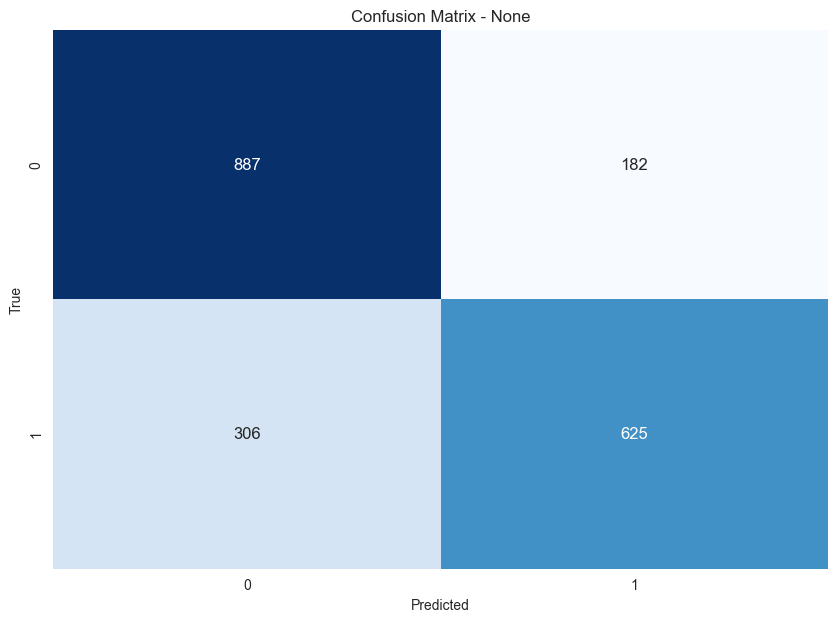

In [20]:
show_conf_matrices(irl_labels, acc_thresh=0.75, f1_thresh=0.65, savefig=False)

#### RIRL - 410m, 30 epochs over 10 reps

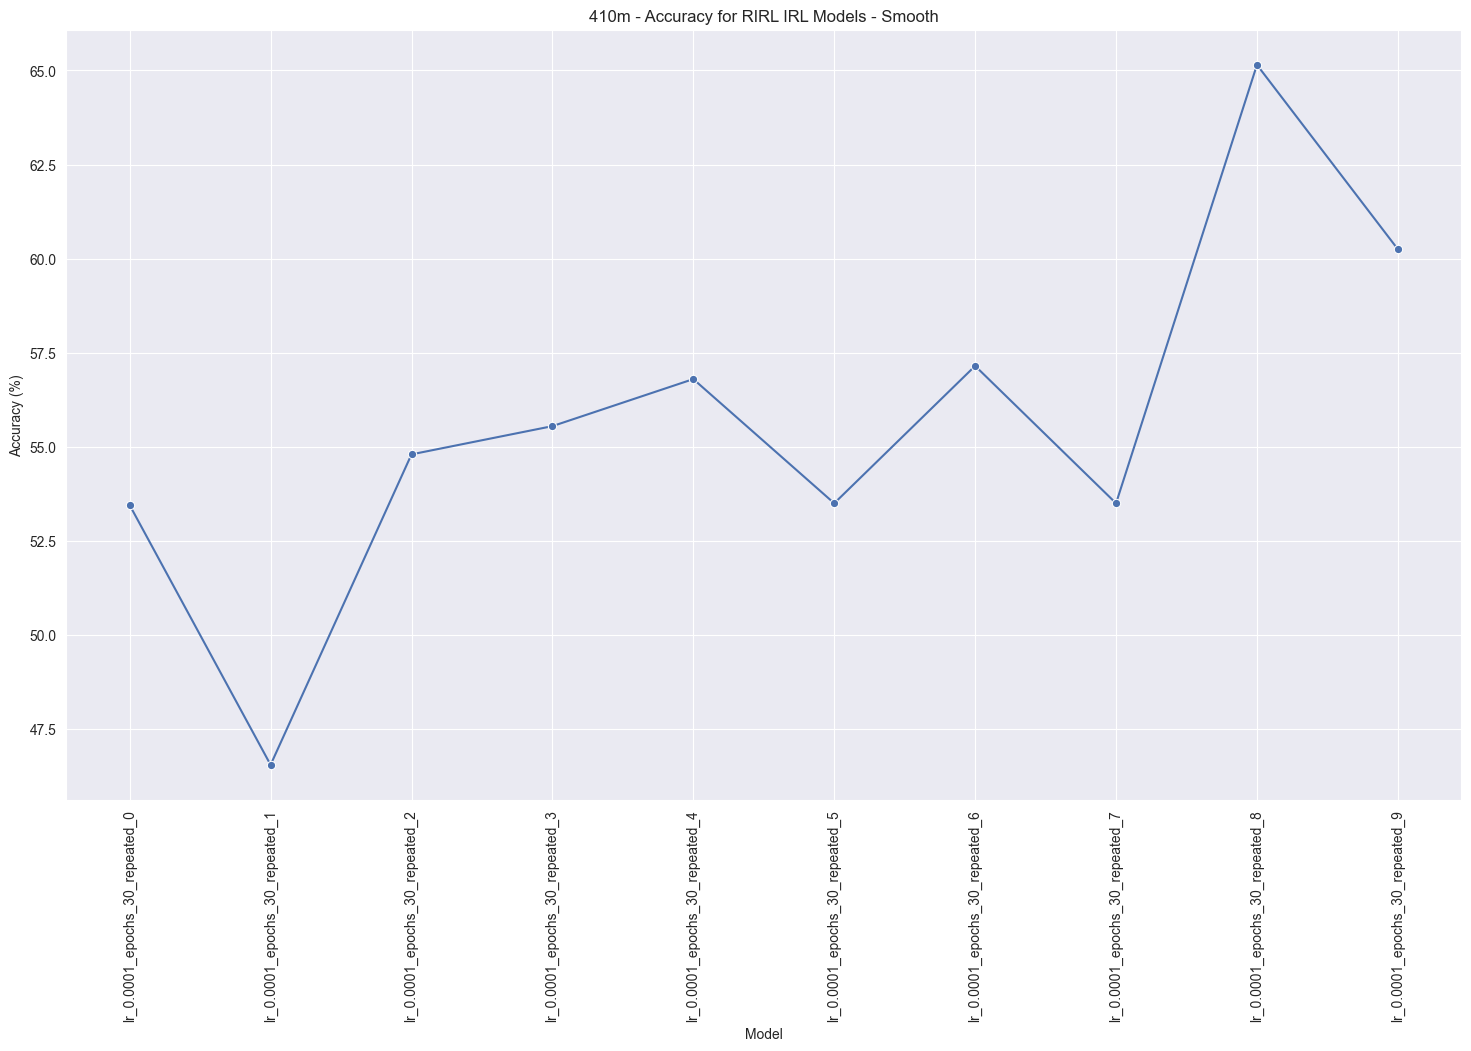

In [150]:
# load results
file_name = 'irl_labels_410m_rirl_30_epochs_lr_0.0001.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=1, savefig=False)

#### RIRL - 410m, 6 epochs over 30 reps

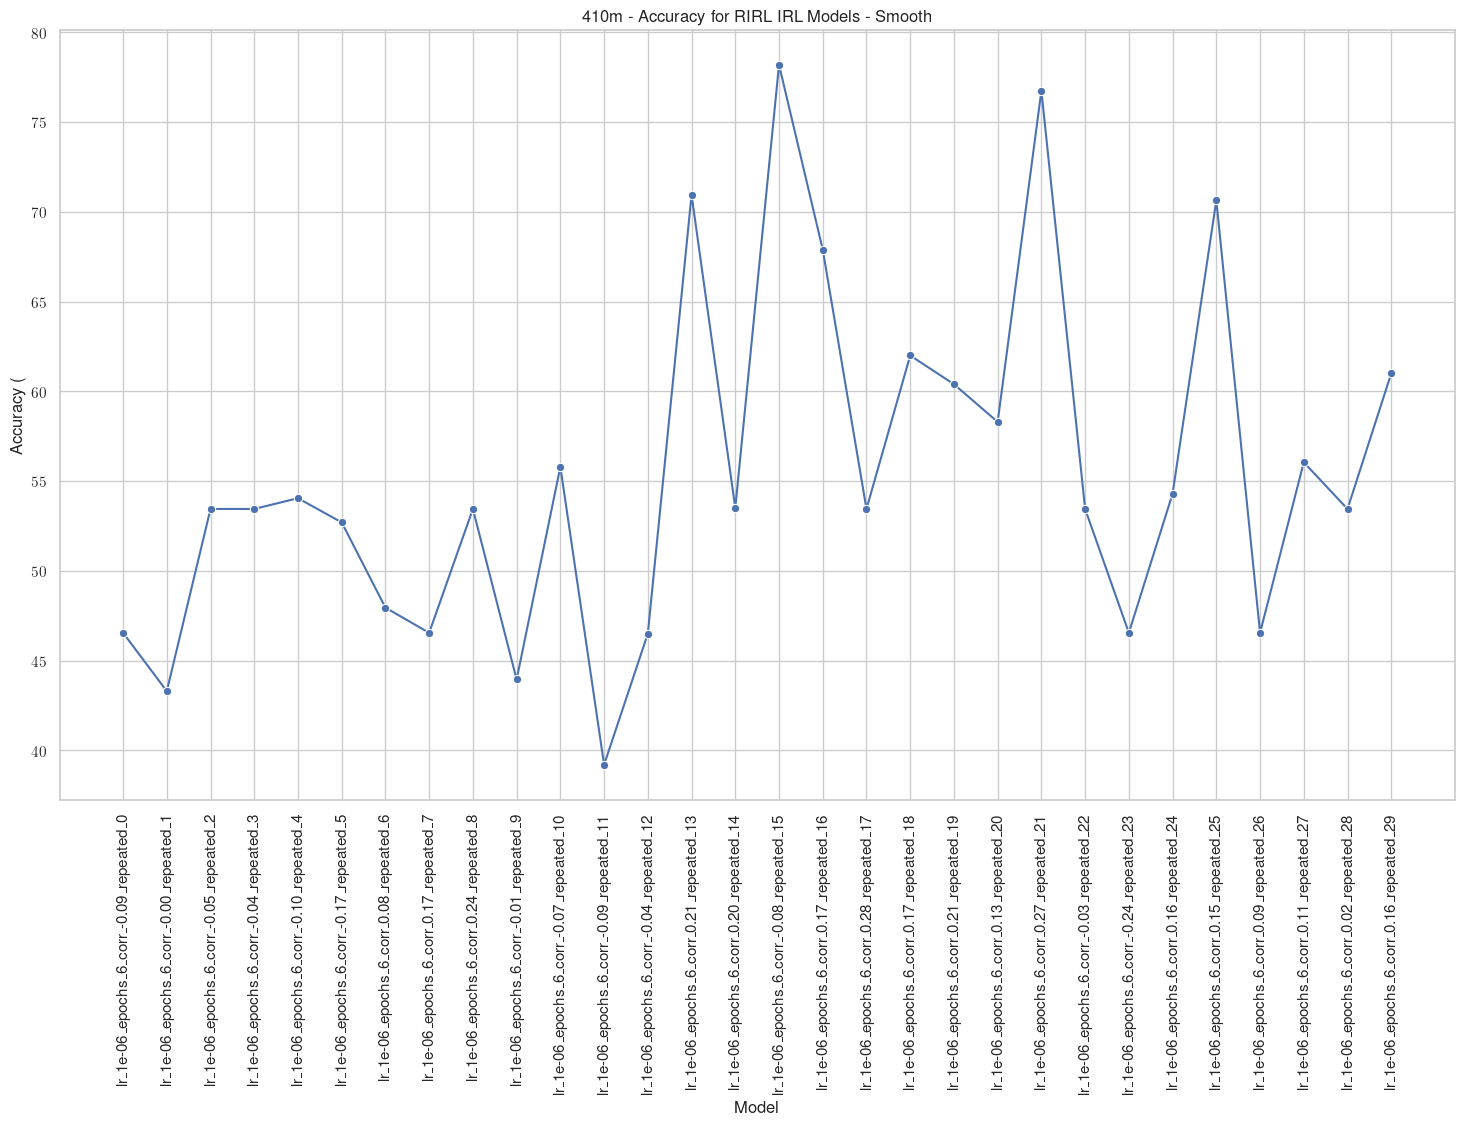

In [192]:
# load results
file_name = 'irl_labels_410m_rirl_6_epochs_30_reps.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=1, savefig=False)

Non-Toxic Labels:  1069
Toxic Labels:  931

Model:  true_reward
Accuracy:   1.0
F1-Score:   1.0
true_reward_acc_1.00_f1_1.00


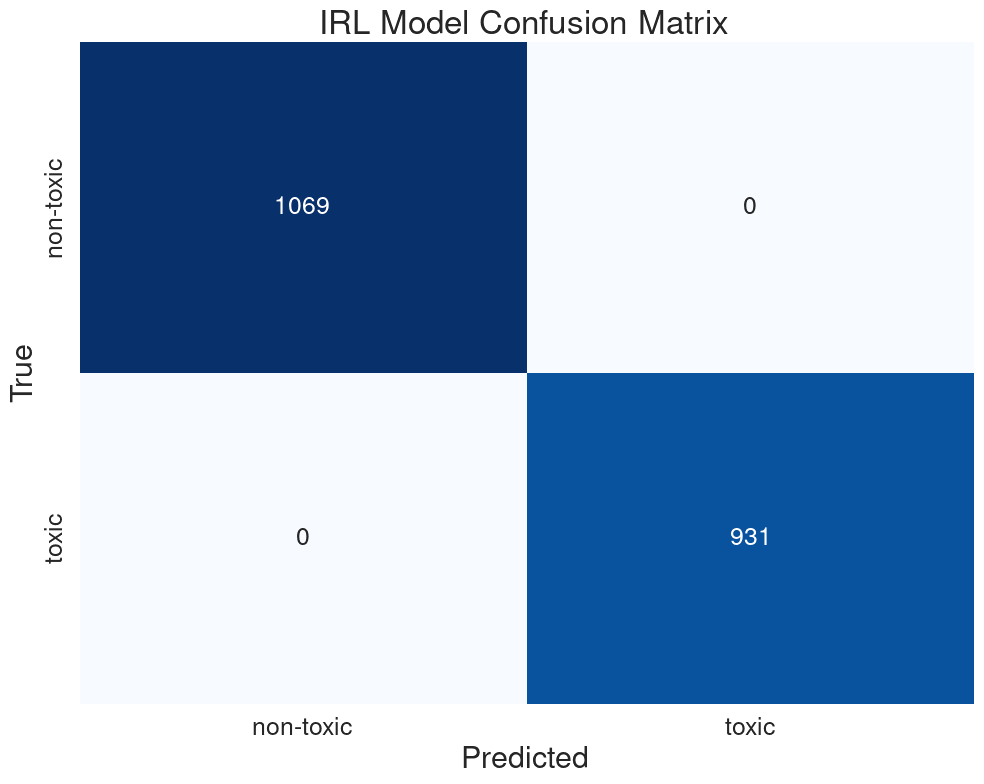


Model:  learned_rm_EleutherAI-pythia-410m_s-nlp-roberta_toxicity_classifier_6_epochs_lr_1e-06_repeated_15_ss_200_corr_-0.08.pt
Accuracy:   0.782
F1-Score:   0.7161458333333334
pythia-410m_s-nlp-roberta_toxicity_classifier_6_epochs_lr_1e-06_repeated_15_ss_200_corr_-0.08_acc_0.78_f1_0.72


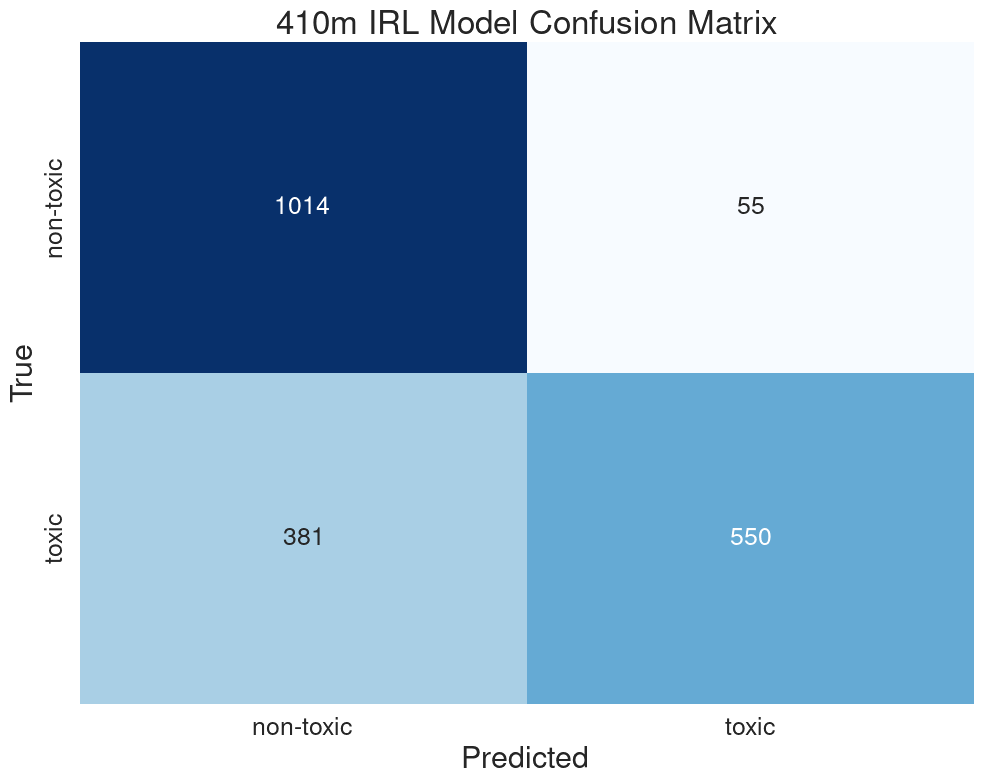

In [193]:
show_conf_matrices(irl_labels, acc_thresh=0.75, f1_thresh=0.70, savefig=True)

#### RIRL - 410m, 8 epochs over 30 reps

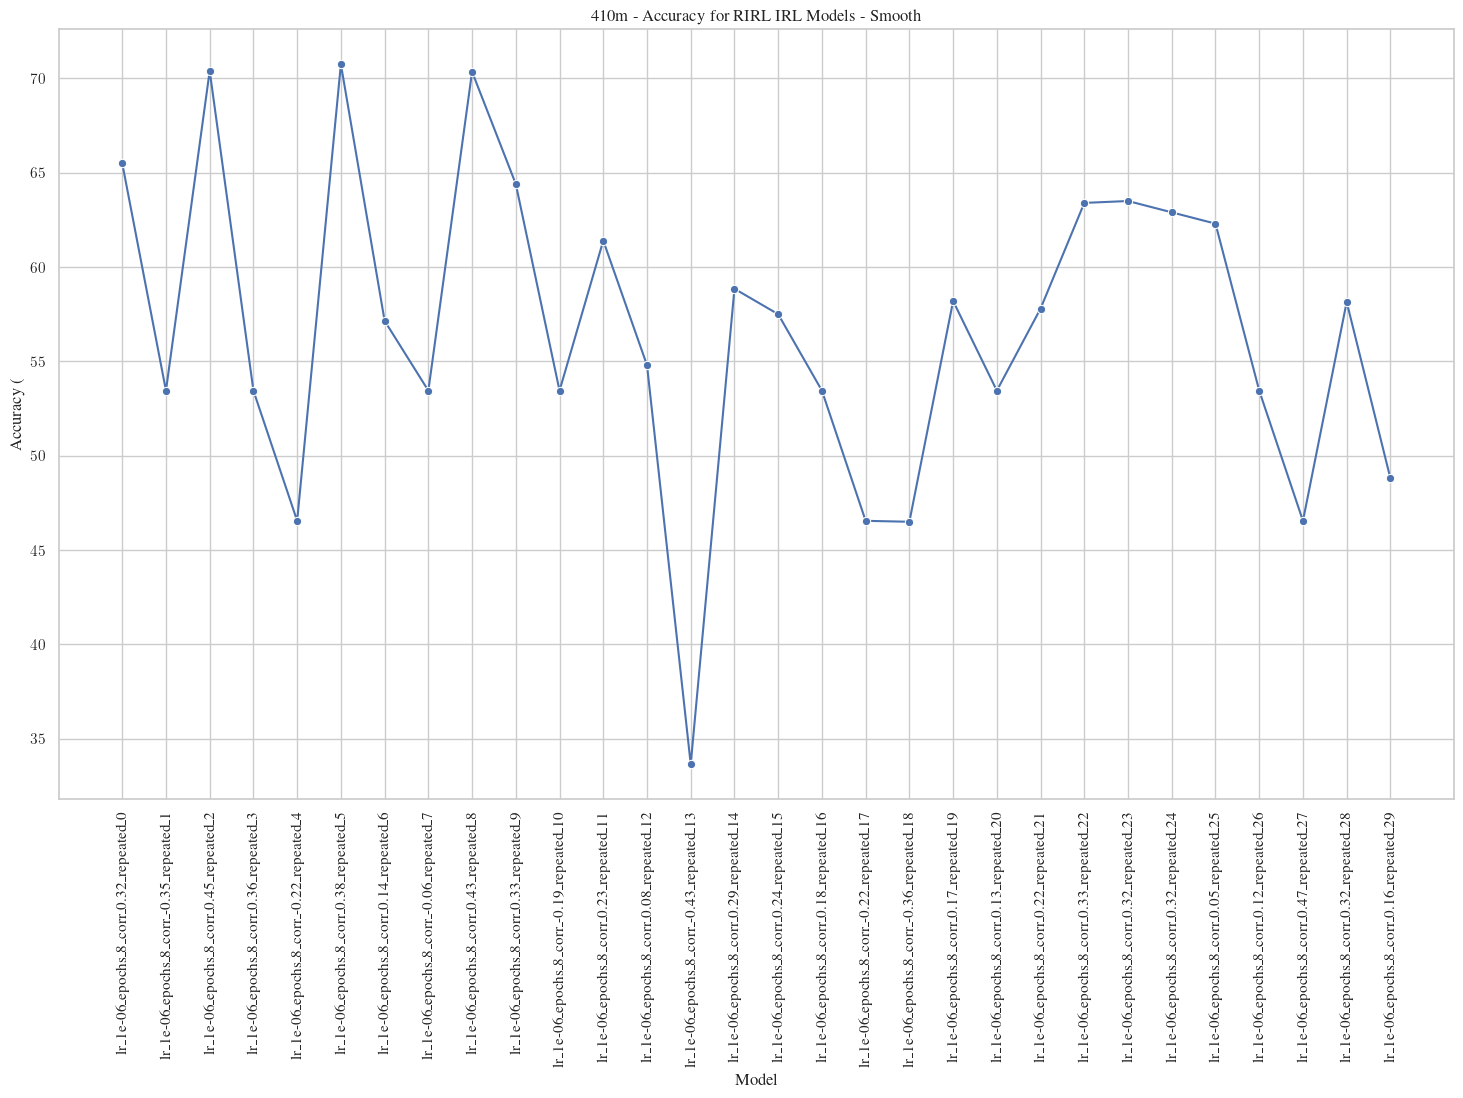

In [347]:
# load results
file_name = 'irl_labels_410m_rirl_8_epochs_30_reps.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=1, savefig=False)

#### RIRL - 410m, 10 epochs over 30 reps

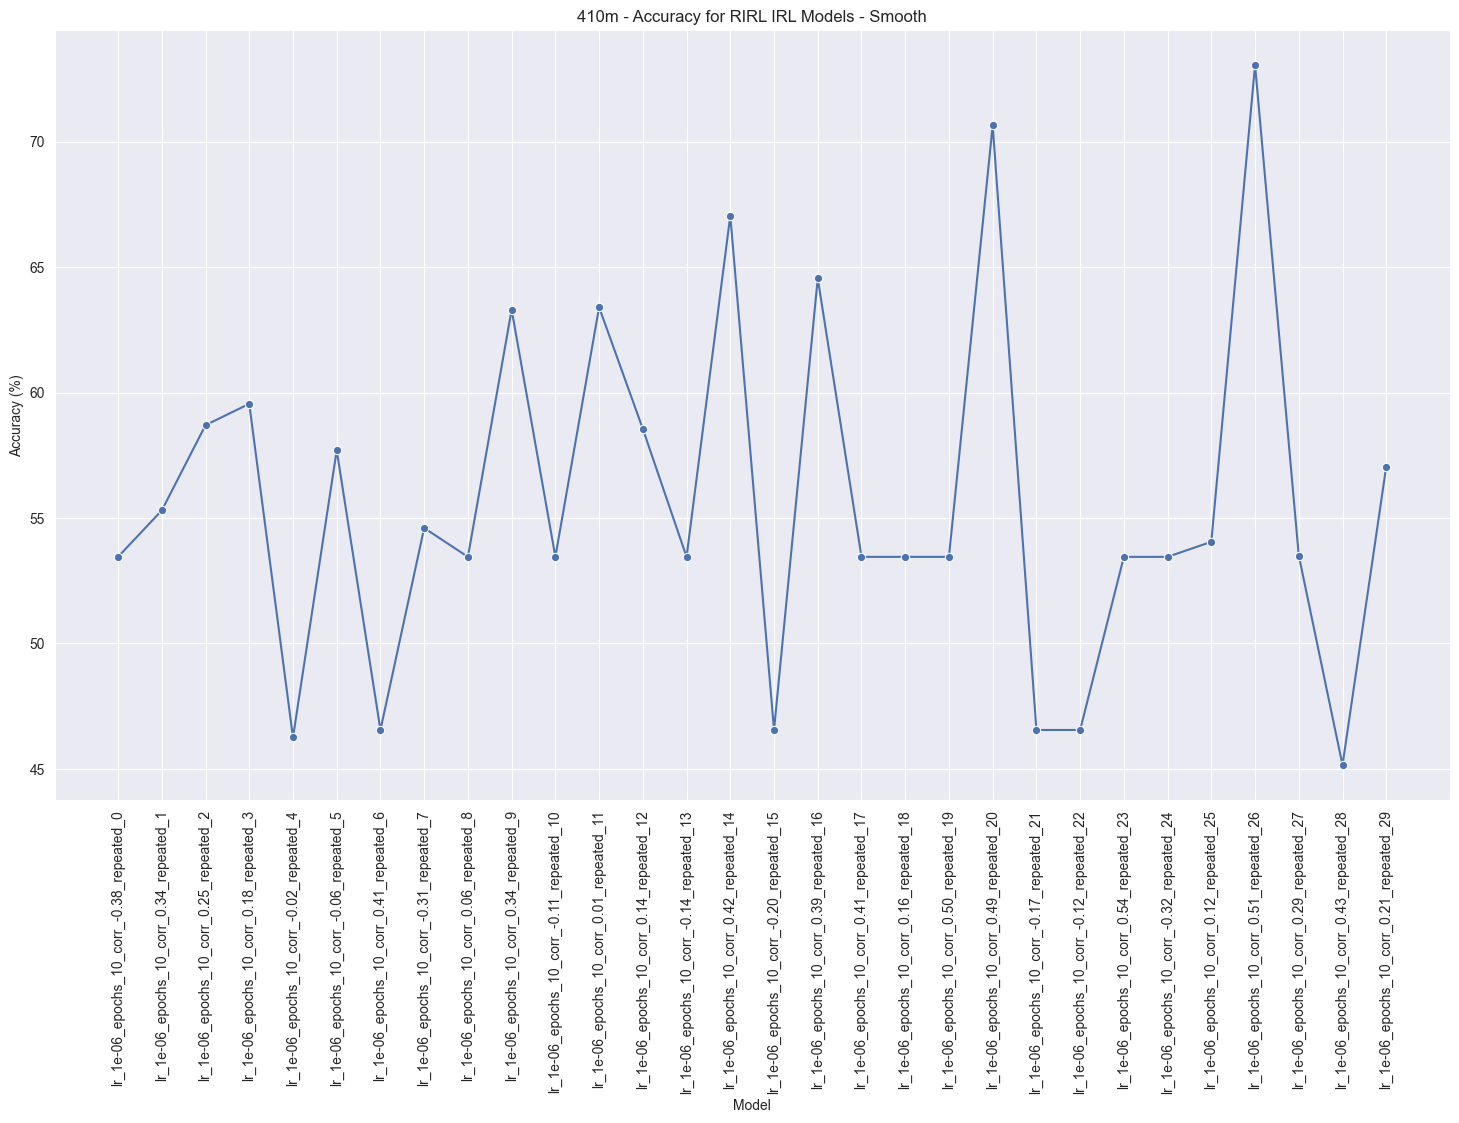

In [157]:
# load results
file_name = 'irl_labels_410m_rirl_10_epochs_30_reps.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/{file_name}'))

plot_reward_comparison(irl_labels, file_name, plt_type='line', smooth_window=1, savefig=False)

### Analysis

#### Single IRL

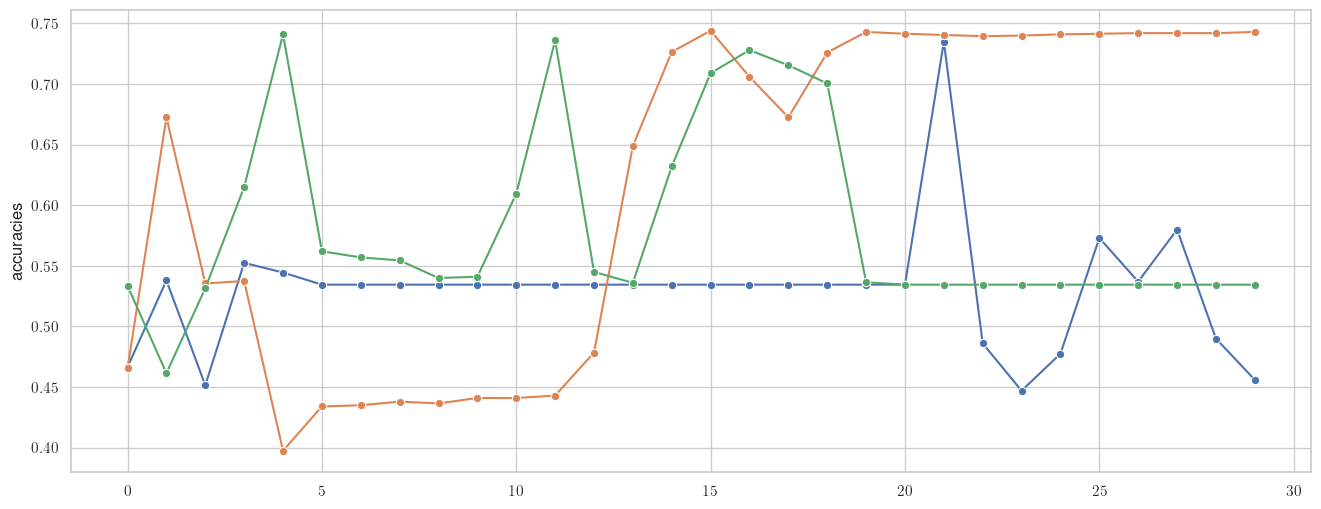

In [168]:
## 30 epochs
# plot multiple runs on the same plot for comparison, based on a  pattern
pattern = 'results/irl/loss_corr/results_30_epochs_lr_0.0001_jaredjoss-jigsaw-long-2000_70m_ss_100_acc_*.json'
files = glob.glob(pattern)
plt.figure(figsize=(16, 6))
for file in files:
    df = pd.read_json(file).head(30)
    # get lr from file name:
    lr = re.findall(r'lr_(.*?)(_|.json)', file)[0][0]
    sns.lineplot(data=df['accuracies'], marker='o', label=None)

#### Naive RIRL

In [162]:
def plot_comparison(file_names, smoothing_span=10):
    def load_and_process_data(file_name):
        # Load data
        irl_labels = json.load(open(f'results/irl/labels_rewards/irl_labels_{file_name}'))

        # Sort data
        irl_labels_sorted = dict(sorted(irl_labels.items(), key=lambda item: get_identifier(item[0], 'rirl')))

        # Get true reward
        true_reward = irl_labels_sorted['true_reward']

        # Calculate accuracies
        accuracies = {}
        for model, predictions in irl_labels_sorted.items():
            if model == 'true_reward':
                continue
            accuracy = accuracy_score(true_reward, predictions)
            accuracies[construct_name(model)] = accuracy
        
        return accuracies

    plt.figure(figsize=(12, 8))
    
    # Process and plot data for each file
    for idx, file_name in enumerate(file_names):
        accuracies = load_and_process_data(file_name)

        # Convert dictionary to list of values
        y = list(accuracies.values())
        
        # Apply EWMA smoothing
        smoothed_y = pd.Series(y).ewm(span=smoothing_span).mean()

        # Plot the dataset on the plot
        sns.lineplot(x=range(len(smoothed_y)), y=smoothed_y, marker='o', label=file_name)
    
    # Add labels, title, and legend
    plt.xlabel('Repetition')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Different RIRL Models')
    plt.legend()

    # Show the plot
    plt.show()

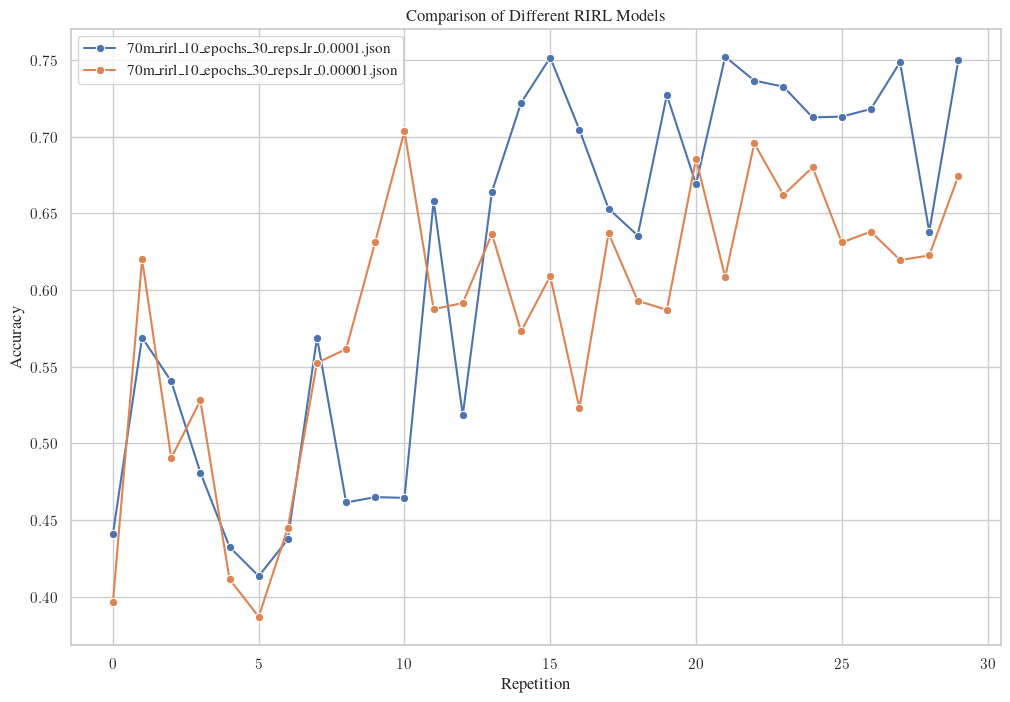

In [348]:
# 10 epochs, different learning rates
plot_comparison(['70m_rirl_10_epochs_30_reps_lr_0.0001.json', '70m_rirl_10_epochs_30_reps_lr_0.00001.json'], smoothing_span=1)

#### Single vs RIRL

In [25]:
# load results
files = ['70m_rirl_10_epochs_30_reps_lr_0.0001.json', 'irl_labels_70m_rirl_10_epochs_30_reps_2.json']

file_name = '70m_rirl_10_epochs_30_reps_lr_0.0001.json'
irl_labels = json.load(open(f'results/irl/labels_rewards/irl_labels_{file_name}'))
# irl_rewards = json.load(open(f'results/irl/labels_rewards/irl_rewards_{file_name}'))



In [56]:
def calculate_accuracy(true_labels, model_labels):
    """Calculate the accuracy of a model given the true labels."""
    correct_predictions = sum(1 for true, pred in zip(true_labels, model_labels) if true == pred)
    return correct_predictions / len(true_labels)

def parse_repeated_value(model_name):
    """Extract the repeated_x value from the model name using regex."""
    match = re.search(r"repeated_(\d+)", model_name)
    return int(match.group(1)) if match else None

def process_json_files(json_files):
    """Process all JSON files and calculate average accuracies and standard deviations."""
    repeated_accuracies = {}  # Dictionary to hold accuracies for each repeated_x

    for file_path in json_files:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        true_labels = data.get("true_reward", [])

        for model_name, model_labels in data.items():
            if model_name == "true_reward":
                continue

            repeated_x = parse_repeated_value(model_name)
            if repeated_x is not None:
                accuracy = calculate_accuracy(true_labels, model_labels)

                # Append accuracy to the list for the corresponding repeated_x
                if repeated_x not in repeated_accuracies:
                    repeated_accuracies[repeated_x] = []
                repeated_accuracies[repeated_x].append(accuracy)

    # Calculate the average accuracy and standard deviation for each repeated_x
    data = {
        'Repeated Iteration': [],
        'Average Accuracy': [],
        'Standard Deviation': []
    }

    for key, values in repeated_accuracies.items():
        data['Repeated Iteration'].append(key)
        data['Average Accuracy'].append(np.mean(values))
        data['Standard Deviation'].append(np.std(values))

    return pd.DataFrame(data)

def plot_accuracies_with_error_bars(df):
    """Plot the average accuracies with standard deviation error bars using Seaborn."""
    df.sort_values(by='Repeated Iteration', inplace=True)
    df = df.head(30)
    plt.figure(figsize=(10, 6))

    # Create a Seaborn barplot without default error bars
    sns.barplot(
        x='Repeated Iteration', 
        y='Average Accuracy', 
        data=df, 
        capsize=0.2, 
        palette='Blues',
        errorbar=None
    )

    # Add error bars manually using Matplotlib
    plt.errorbar(
        x=df['Repeated Iteration'], 
        y=df['Average Accuracy'], 
        yerr=df['Standard Deviation'], 
        fmt='none', 
        c='black', 
        capsize=5
    )

    plt.xlabel('Repeated Iteration (x)')
    plt.ylabel('Average Accuracy')
    plt.title('Average Accuracy for Models at Each Repeated Iteration with Standard Deviation')
    plt.grid(axis='y')
    plt.show()

#### Best models

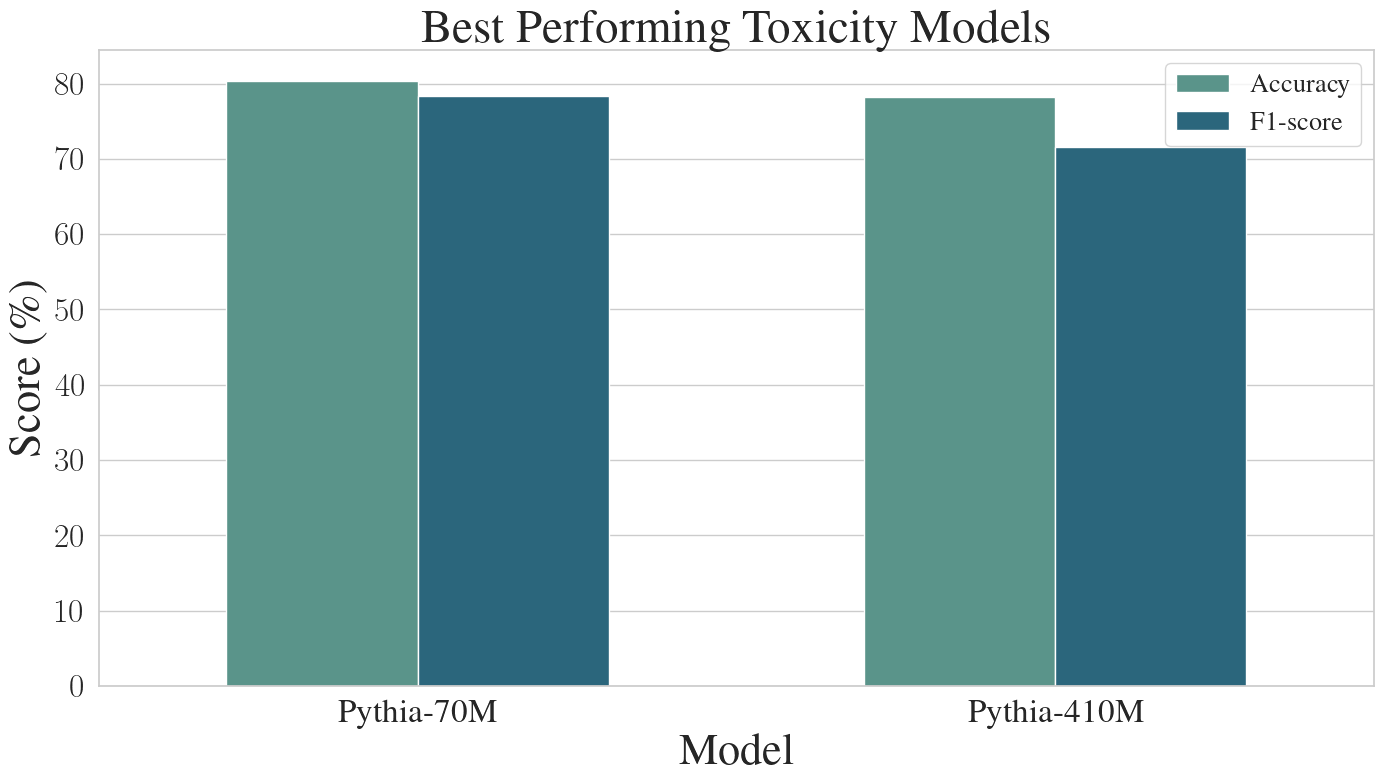

In [346]:
data = {
    'Model': ['Pythia-70M', 'Pythia-70M', 'Pythia-410M', 'Pythia-410M'],
    'Metric': ['Accuracy', 'F1-score', 'Accuracy', 'F1-score'],
    'Value': [80.40, 78.39, 78.20, 71.61]  # Example values for accuracy and F1-score
}

df = pd.DataFrame(data)

# Create the seaborn plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Value', hue='Metric', data=df, palette='crest', width=0.6)


# Customize the plot
plt.title('Best Performing Toxicity Models', fontsize=34)
plt.xlabel('Model', fontsize=32)
plt.ylabel('Score (\%)', fontsize=32)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(title='', fontsize=19)

plt.tight_layout()
plt.savefig('plots/irl/best_toxicity_models.png', dpi=1200, transparent=True)
plt.show()